## SETUP

In [1]:
# TOOLS
# %load START.py
import ipywidgets as widgets
import xarray as xr
import xesmf as xe # regradeador
import glob
import sys
import os
import fileinput
from netCDF4 import Dataset
import h5py
#from global_land_mask import globe
from pathlib import Path
from numpy import diff
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import copy
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import numpy as np
from time import time
##
import six
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from netCDF4 import Dataset
from numpy import diff
from matplotlib.collections import RegularPolyCollection
import matplotlib.patches as mpatches
import copy
sys.modules['sklearn.externals.six'] = six
#import mlrose DELETAR
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import sompy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable


def smooth(x,window_len=1,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

def MOD_ssta(sstc,lat,lon):
    
    ssta=copy.deepcopy(sstc)
        
    for i in range(len(sstc)):
        
        sst=sstc[i] # shape: (1200,360,180)
        end=len(sst)
        mediasst=copy.deepcopy(sst[0:12,:,:])
        for j in range(12):
            zz=copy.deepcopy(sst[j:end:12,:,:])
            mediasst[j,:,:]=np.mean(zz[:,:,:], axis=0)
        
        #CALCULO DO VETOR A ANOMALIA DE SST
        for t in range(12):
            ssta[i,t:end:12,:,:]=sst[t:end:12,:,:]-mediasst[t,:,:]
        
    # Média global de SSTA
    gssta=np.nanmean(np.nanmean(ssta,2),2)
    # retira serie temporal da média global
    sstaa=copy.deepcopy(ssta)
    for t in range(len(ssta)):
        for i in range(len(ssta[0,0])):
            for j in range(len(ssta[0,0,0])):
                sstaa[t,:,i,j]=ssta[t,:,i,j]-gssta[t]
    
    return sstaa

def MOD_anomalia(vetor,lat,lon):
    # calcula a anomalia dos diferentes modelos dentro do vetor
    
    anomalia=copy.deepcopy(vetor)
        
    for i in range(len(vetor)):
        
        # Climatologia 
        temp=vetor[i] # shape: (1200,lon,lat)
        end=len(temp)
        mediatemp=copy.deepcopy(temp[0:12,:,:])
        for j in range(12):
            zz=copy.deepcopy(temp[j:end:12,:,:])
            mediatemp[j,:,:]=np.nanmean(zz[:,:,:], axis=0) # vetor com médias/climatologia
        
        #CALCULO DO VETOR ANOMALIA
        for t in range(12):
            anomalia[i,t:end:12,:,:]=temp[t:end:12,:,:]-mediatemp[t,:,:]
    
    return anomalia

def MOD_anomaliaindividual(vetor,lat,lon):
    # calcula anomalia do vetor (tempo,lat,lon)
    
    anomalia=copy.deepcopy(vetor)
        
    # Climatologia 
    temp=vetor # shape: (1200,lon,lat)
    end=len(temp)
    mediatemp=copy.deepcopy(temp[0:12,:,:])
    for j in range(12):
        zz=copy.deepcopy(temp[j:end:12,:,:])
        mediatemp[j,:,:]=np.nanmean(zz[:,:,:], axis=0) # vetor com médias/climatologia
    
    #CALCULO DO VETOR ANOMALIA
    for t in range(12):
        anomalia[t:end:12,:,:]=temp[t:end:12,:,:]-mediatemp[t,:,:]
    
    return anomalia

def anomaliassthistorica(local):
    # recorta dado
    dataset = Dataset(local)
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    lon = np.insert(lon, len(lon),360)
    lon[0]=0
    sstc = dataset.variables['sst']
    
    ##de 1870-2019 = 1788 meses
    # Os ultimos 8 meses estão faltando
    sst=sstc[0:1788]
    end=len(sst)
    
    #climatologia em função de 1979-2014
    end=len(sst)
    mediasst=copy.deepcopy(sst[0:12,:,:])
    for i in range(12):
        zz=copy.deepcopy(sstc[i+12*109:12*109+432:12,:,:])
        mediasst[i,:,:]=np.mean(zz[:,:,:], axis=0)

    #CALCULO DO VETOR A ANOMALIA DE SST
    ssta=copy.deepcopy(sst[:,:,:])
    for t in range(12):
        ssta[t:end:12,:,:]=sst[t:end:12,:,:]-mediasst[t,:,:]

    # retira serie temporal da média global de 1970 - 2019
    gssta=np.nanmean(np.nanmean(ssta[end-12*49:end],1),1)
    sstaa=copy.deepcopy(ssta)
    for i in range(len(ssta[0])):
        for j in range(len(ssta[0,0])):
            sstaa[end-12*49:end,i,j]=ssta[end-12*49:end,i,j]-gssta
    
    # retira serie temporal da média global de 1870 - 1970
    ggssta=np.nanmean(np.nanmean(ssta[0:end-12*49],1),1)
    for i in range(len(ssta[0])):
        for j in range(len(ssta[0,0])):
            sstaa[0:end-12*49,i,j]=ssta[0:end-12*49,i,j]-ggssta
    
    
    
    return sstaa

def anomaliasst(local):
    # recorta dado
    dataset = Dataset(local)
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:] # esta de -179,5 até 179,5
    #lon = np.insert(lon, len(lon),360)
    #lon[0]=0
    sstc = dataset.variables['sst']
    
    # Climatologia para 1979-2014
    sst=sstc[12*109:12*109+432]
    end=len(sst)
    mediasst=copy.deepcopy(sst[0:12,:,:])
    for i in range(12):
        zz=copy.deepcopy(sst[i:end:12,:,:])
        mediasst[i,:,:]=np.mean(zz[:,:,:], axis=0)
        
    #CALCULO DO VETOR A ANOMALIA DE SST
    ssta=copy.deepcopy(sst[:,:,:])
    for t in range(12):
        ssta[t:end:12,:,:]=sst[t:end:12,:,:]-mediasst[t,:,:]
        
    # Média global de SSTA de 1979 - 2014
    gssta=np.nanmean(np.nanmean(ssta,1),1)
    # retira serie temporal da média global
    sstaa=copy.deepcopy(ssta)

    for i in range(len(ssta[0])):
        for j in range(len(ssta[0,0])):
            sstaa[:,i,j]=ssta[:,i,j]-gssta
    
    return sstaa, lon, lat

def anomaliappt(local):
    dataset = Dataset(local)
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    lon[len(lon)-1]=180
    lon[0]=-180
    pptc = dataset.variables['precip'][:]
    
    # Climatologia para 1979-2014
    ppt=pptc[0:432]
    end=len(ppt)
    mediappt=copy.deepcopy(ppt[0:12,:,:])
    for i in range(12):
        z=copy.deepcopy(ppt[i:len(ppt):12,:,:])
        mediappt[i,:,:]=np.mean(z[:,:,:], axis=0)
    
    #CALCULO DO VETOR A ANOMALIA
    ppta=copy.deepcopy(ppt[:,:,:])
    for t in range(12):
        ppta[t:end:12,:,:]=ppt[t:end:12,:,:]-mediappt[t,:,:]
    
    
    return ppta, lon, lat

def anomaliaslp(local):
    dataset = Dataset(local)
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    pslc = dataset.variables['pres'][:]
    
    #CLimato
    psl=pslc[31*12:31*12+432]
    end=len(psl)
    mediapsl=copy.deepcopy(psl[0:12,:,:])
    for i in range(12):
        zzz=copy.deepcopy(psl[i:end:12,:,:])
        mediapsl[i,:,:]=np.mean(zzz[:,:,:], axis=0)
    
    #Anomalia
    psla=copy.deepcopy(psl[:,:,:])
    
    for t in range(12):
        psla[t:end:12,:,:]=psl[t:end:12,:,:]-mediapsl[t,:,:]

    return psla, lon, lat

def anomaliawind(local):
    dataset = Dataset(local)
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    try:
        wind = dataset.variables['uwnd'][:]
    except:
        wind = dataset.variables['vwnd'][:]

    #CLimato
    tau=wind[31*12:31*12+432]
    end=len(tau)
    media=copy.deepcopy(tau[0:12,:,:])
    for i in range(12):    
        zzzz=copy.deepcopy(tau[i:end:12,:,:])
        media[i,:,:]=np.mean(zzzz[:,:,:], axis=0)
    
    #Anomalia
    taua=copy.deepcopy(tau[:,:,:])
    
    for t in range(12):
        taua[t:end:12,:,:]=tau[t:end:12,:,:]-media[t,:,:]
        
    return taua, lon, lat
import warnings

import sklearn

    
def progressbar(it, prefix="", size=40, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        space=int((size-18)/2)
        a='#'*space
        mensagem = a + ' VAI CORINTHIANS! ' + a
        porcentagem=str(int(j/it[-1]*100))
        file.write("%s[%s%s] %s\r" % (prefix, mensagem[0:x], "."*(size-x), porcentagem+'%')) # imprime porcentual á cumprido
        # file.write("%s[%s%s] %i/%i\r" % (prefix, mensagem[0:x], "."*(size-x), j, count)) # imprime numero_bruto/total na contagem da porcentagem
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

def mascara(ssta,lat,lon): # cria mascara global dos dados sobre o continente
    global mask
    #CORTES ATLANTICO
    ## de 65W à 25E - 50S à 30N
    sstAtl=np.ma.concatenate((sstaa[:,40:120,0:25],sstaa[:,40:120,295:360]),axis=2)
    nt,nx,ny = sstAtl.shape
    lata=lat[40:120]
    lona = np.ma.concatenate((lon[0:25],lon[295:360]),axis=0)


    # Mascara SST (retira valores '--')
    arr = np.random.randn(nx, ny)
    mask = arr < 1
    count = 0
    for x in range(nx):
        for y in range(ny):
            if str(sstAtl[0,x,y])=='--':
                mask[x,y]=False
            else: 
                mask[x,y]=True
                count=count+1
    latx=np.zeros((count))  
    lony=np.zeros((count))  
    b=0
    for x in range(nx):
        for y in range(ny):
            if mask[x,y]==True:
                latx[b]=lata[x]
                lony[b]=lona[y]
                b=b+1
                
    return mask, latx, lony
def Vetoriza(matriz,dim,mascara):
   # vetoriza matriz de dim=dimensao para 2 dimensoes de acordo com mascara espacial
    # a ideia é, se existem 3 dimenoes, 1é temporal e 2 espaciais
    # se existem 4, uma é o modelo, uma temporal e 2 espaciais.
    matriz=np.array(matriz)
    if dim == 4:
        vetor=np.concatenate(matriz[:,:,mascara],axis=0)
    elif dim == 3:
        vetor=matriz[:,mascara]
    return vetor

def SPI(dado,Box):
    # recebe precipitacao da regiao e devolve somatoria dentro do Box (obs: o Box é uma mascara)

    SPI = np.sum(dado[Box])
    
    return SPI

def Variedade(vetor):
    # CALCULA QUANTOS NÚMEROS DIFERENTES EXISTEM EM UM VETOR E QUANTOS SE REPETEM
    
    Variedade = []
    repete=0
    
    for i in vetor:
        if int(i) in Variedade:
            repete=repete+1
        else:
            Variedade.append(int(i))
        
    return len(Variedade),repete
            
def BMU(porcentagem):
    # CALCULA BMU APARTIR DA MATRIZ DE PORCENTAGEM DE CORRELACAO ENTRE SOM E DADOS
    
    tempo=len(porcentagem[0])
    BMU=np.zeros((2,tempo))
    for t in range(tempo): # tempo da série temporal
        
        # # # # # # # # # Se porcentagem é um vetor estritamente positivo tenho que filtrar os passos temporais que não tem correlacao com nenhum padrao. Caso contrario o padrao 0 será sempre escolhido
        #pula=True
        #for padrao in range(porcentagem.shape[0]):
        #    if porcentagem[padrao,t] > 0:
        #        pula = False # Se há algum valor for não nulo, busco o BMU desse tempo
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
        #if pula:
        #    BMU[0,t]=None
        #    BMU[1,t]=None
        #else:
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
        
        BMU[0,t]=porcentagem[:,t].argmax()
        BMU[1,t]=np.max(porcentagem[:,t])
        
    return BMU


# Preambulo GMD Scripts

## Cria os vetores de anomalias

In [2]:
### BAIXA DADOS - VETORES SALVOS

tos=np.load('tos2.npy')
ppt=np.load('ppt2.npy')
lat=np.load('lat.npy')
lon=np.load('lon.npy')


## Substitui partes vazias dos vetores por valores Nan.
for m in range(tos.shape[0]):
    if tos[m,700,0,0]<1:
        tos[m,600:tos.shape[1],:,:]=np.nan
        ppt[m,600:ppt.shape[1],:,:]=np.nan
    if tos[m,1700,0,0]<1:
        tos[m,1200:tos.shape[1],:,:]=np.nan
        ppt[m,1200:ppt.shape[1],:,:]=np.nan

# passa de mm/dia para kg m^2 s^-1

for t in range(ppt.shape[1]):
    #for lat in range(ppt.shape[2]):
    #    for lon in range(ppt.shape[3]):
    ppt[8:14,t] = ppt[8:14,t]/86400 # Passa de mm/dia para kg m^-2 s^-1
    ppt[14:17,t] = ppt[14:17,t]*1000 # passa de m/s para kg m^-2 s^-1

    
    # Pega mascara do Atlantico do 1o modelo e aplica a todo vetor de temperatura

mascara = ( tos[0,0,:,:] < -100 )

for i in range(len(mascara)):
    for j in range(len(mascara[0])):
        if tos[0,0,i,j] == 0 or tos[0,0,i,j] == np.nan:
            mascara[i,j] = True
            
tos[:,:,mascara]=np.nan

## CALCULA ANOMALIAS

Mtosa = MOD_anomalia(tos,lat,lon)
Mppta = MOD_anomalia(ppt,lat,lon)



/tmp/ipykernel_12152/2721577200.py:153: RuntimeWarning: Mean of empty slice
  mediatemp[j,:,:]=np.nanmean(zz[:,:,:], axis=0) # vetor com médias/climatologia


In [3]:

# MASCARA DE VALORES VALIDOS PARA O SOM da SST (masca) e PPT (fullmask)
masca=~mascara
fullmask = copy.deepcopy(masca)
fullmask[:]=True

# DEFINE QUANTIDADE DE CADA MODELO QUE SERA UTILIZADA NO TrEINO DO SOM
train=np.zeros((Mtosa.shape[0],600),dtype=int)
lista2400 = [1,3,7] # modelos com rodadas de 200 anos
lista1200 = [0,2,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20] # modelos com rodadas de 100 anos
lista600 = [5] # modelos com rodadas de 50 anos
lista = np.arange(0,21)

## PASSA FILTRO DECADAL
filtro=120
        
for m in lista2400:
    for l in range(Mtosa.shape[2]):
        for ln in range(Mtosa.shape[3]):
            Mtosa[m,:,l,ln]=smooth(Mtosa[m,:,l,ln],filtro)
            Mppta[m,:,l,ln]=smooth(Mppta[m,:,l,ln],filtro)
            
            #ppt_smooth[m,:,l,ln]=smooth(ppt[m,:,l,ln],filtro)
for m in lista1200:
    for l in range(Mtosa.shape[2]):
        for ln in range(Mtosa.shape[3]):
            Mtosa[m,:1200,l,ln]=smooth(Mtosa[m,:1200,l,ln],filtro)
            Mppta[m,:1200,l,ln]=smooth(Mppta[m,:1200,l,ln],filtro)
            #ppt_smooth[m,:,l,ln]=smooth(ppt[m,:,l,ln],filtro)
for m in lista600:
    for l in range(Mtosa.shape[2]):
        for ln in range(Mtosa.shape[3]):
            Mtosa[m,:600,l,ln]=smooth(Mtosa[m,:600,l,ln],filtro)
            Mppta[m,:600,l,ln]=smooth(Mppta[m,:600,l,ln],filtro)
            #ppt_smooth[m,:,l,ln]=smooth(ppt[m,:,l,ln],filtro)

#del ppt            
            
## NORMALIZACAO...

for m in range(Mppta.shape[0]):
    Mppta[m] = Mppta[m]*10e4
    #ppt_smooth[m] = ppt_smooth[m]*10e4

    
import sys
import time
### CMAP PARA CHUVA ############################
top = cm.get_cmap('Greens', 12)
bottom = cm.get_cmap('Oranges_r', 12)
newcolors = np.vstack((bottom(np.linspace(0, 1, 12)),
                       top(np.linspace(0, 1, 12))))
cmpchuva = ListedColormap(newcolors, name='OrangeGreen')
################################################

print('foi')


foi


In [4]:
## VETORES COM TODOS OS TOSA E PPTA DOS MODELOS na lista 1200

x = np.zeros(Mtosa.shape[0]) # contador de modelos
for t in range(x.shape[0]):
    if t in lista1200:
        x[t] = 1 

mascara1200 = x > 0

Vtosa = np.concatenate(Mtosa[mascara1200,:1200],axis=0)
Vppta = np.concatenate(Mppta[mascara1200,:1200],axis=0)

## FAZ PCA DOS VETORES Vtosa e Vppta

### PCA  - Modelos

#### PCA SST

In [7]:
### Full PCA
from sklearn.decomposition import PCA

# ESCOLHE APENAS AS 3 PRIMEIRAS COMPONENTES

vetor = Vtosa
xxs = copy.deepcopy(vetor[0:3])
X = vetor.reshape((vetor.shape[0],vetor.shape[1]*vetor.shape[2]))
MASCARA = np.ma.masked_invalid(xxs[0])
X = X[:, ~np.isnan(X).any(axis=0)] # tira valores nan
X = np.swapaxes(X,0,1) # X é lat*lon, tempo
MASCARAv = X != np.nan

p=3
pca = PCA(n_components=p)
pca.fit(X)
xs = pca.transform(X)
xs = xs[:,0:p]
xs =  np.swapaxes(xs,0,1)
xxs[0:3,~MASCARA.mask] = xs # componentes, lat,lon

In [8]:
def PlotSeries(fig, series, color_pos='r',color_neg='b',label_pos=None,label_neg=None,Title=None,start = 0):
    # FUNCAO QUE PLOTA SERIES
    
    #### Linhas constantes de +1 e -1 #
    xx=list(range(0, len(series)))
    x=copy.deepcopy(xx)
    for i in range(len(xx)):
        x[i]=1+(0.5+xx[i])/12
    y=[1]*len(x)
    yy=[-1]*len(x)
    ###################################
    
    plt.fill_between(x, series,
                     where=(series > 0),
                     alpha=0.50, color=color_pos, interpolate=True, label=label_pos)
    plt.fill_between(x, series,
                     where=(series < 0),
                     alpha=0.50, color=color_neg, interpolate=True, label=label_neg)
    
    #fig.title.set_text(Title)
    fig.set_ylabel(Title,fontweight ='bold')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    plt.plot(x[start:len(x)],y[start:len(x)],linestyle=":",color=color_pos,alpha=0.5)
    plt.plot(x[start:len(x)],yy[start:len(x)],linestyle=":",color=color_neg,alpha=0.5)
 
import pylab as pl

def PlotSeries_c(fig, clusters,Title=None,start = 0):
    
    #### Linhas constantes de +1 e -1 #
    xx=list(range(0, len(clusters)))
    x=copy.deepcopy(xx)
    for i in range(len(xx)):
        x[i]=1+(0.5+xx[i])/12
    y=[1]*len(x)
    yy=[-1]*len(x)
    ###################################
    
    fig.title.set_text(Title)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        #bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off
    )

    pl.plot(x, clusters, "")
    antigo =-1
    for xs, cs in zip(x, clusters):
        if antigo != cs:
            pl.text(xs, cs+0.5 , str(int(cs)), color="k", fontsize=12)
            antigo = cs
        else:
            antigo = cs
    fig.set_ylabel('cluster',fontweight ='bold')
    fig.set_xlabel('sim year',fontweight ='bold')
    

locator: <matplotlib.ticker.FixedLocator object at 0x7efe0f92dd50>
locator: <matplotlib.ticker.FixedLocator object at 0x7efe0dfe7430>
locator: <matplotlib.ticker.FixedLocator object at 0x7efe0e08b100>


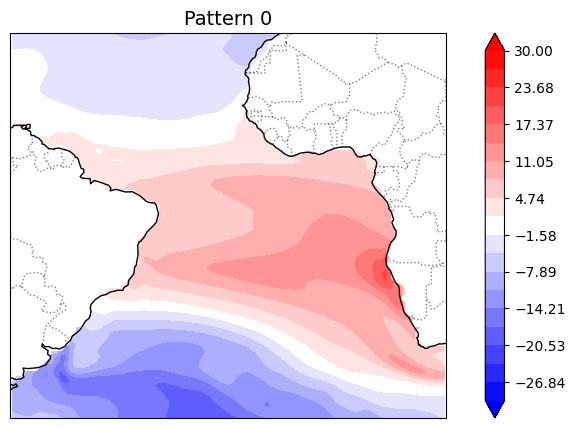

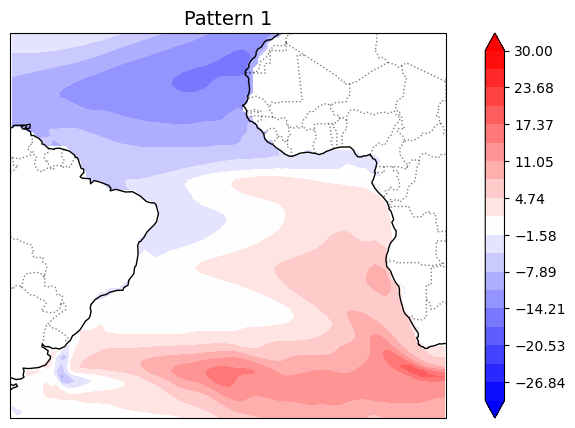

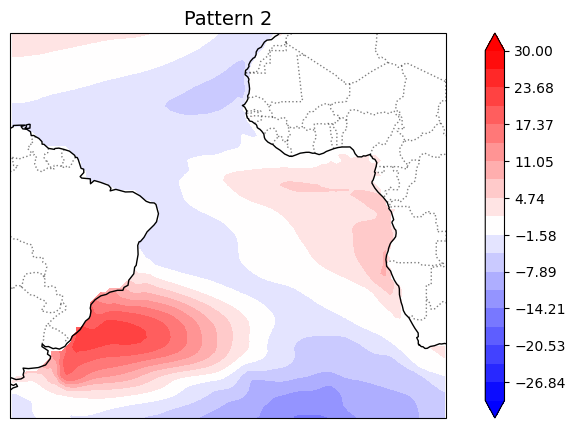

In [10]:
for pattern in [0,1,2]:
    plot = np.squeeze(xxs[pattern]).reshape(len(lat),len(lon))

    levelppt = 30
    levelp = np.linspace(-levelppt,levelppt, 20)
    levelsst = 30
    levels = np.linspace(-levelsst,levelsst, 20)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1, aspect='equal',
                         projection=ccrs.PlateCarree(central_longitude=-90.0, globe=None))

    ax.set_extent([-65, 24, -49, 29.5], ccrs.PlateCarree())
    im = ax.contourf(lon, lat, plot,levels=levelp,cmap='bwr',extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'         
    ax.coastlines(linewidths=1)
    ax.add_feature(cf.BORDERS, linestyle=':', alpha=.5)

    ax.set_title('Pattern '+ str(pattern), fontsize=14)
    plt.colorbar(im)

In [12]:
# projeta mapas ssta do atlantico nas 3 componentes principais (x), criando indice de cada componente
proj1, proj2, proj3 = np.ndarray((17,1200)),np.ndarray((17,1200)),np.ndarray((17,1200))
counter = -1
m=-1

for model in lista1200:
    m+=1
    counter = -1
    for ppt in Mtosa[model][:1200]:
        counter+=1
        ppt = ppt[~np.isnan(ppt)].reshape(ppt[~np.isnan(ppt)].shape[0])
        first = np.squeeze(xxs[0][~np.isnan(xxs[0])]).reshape(ppt.shape[0])
        second = np.squeeze(xxs[1][~np.isnan(xxs[0])]).reshape(ppt.shape[0])
        third = np.squeeze(xxs[2][~np.isnan(xxs[0])]).reshape(ppt.shape[0])

        proj1[m][counter] = np.inner(ppt,first)
        proj2[m][counter] = np.inner(ppt,second)
        proj3[m][counter] = np.inner(ppt,third)

    # divide pelo desvio padrao
    proj1[m] = proj1[m]/np.std(proj1[m])
    proj2[m] = proj2[m]/np.std(proj2[m])
    proj3[m] = proj3[m]/np.std(proj3[m])



top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


<Figure size 640x480 with 0 Axes>

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


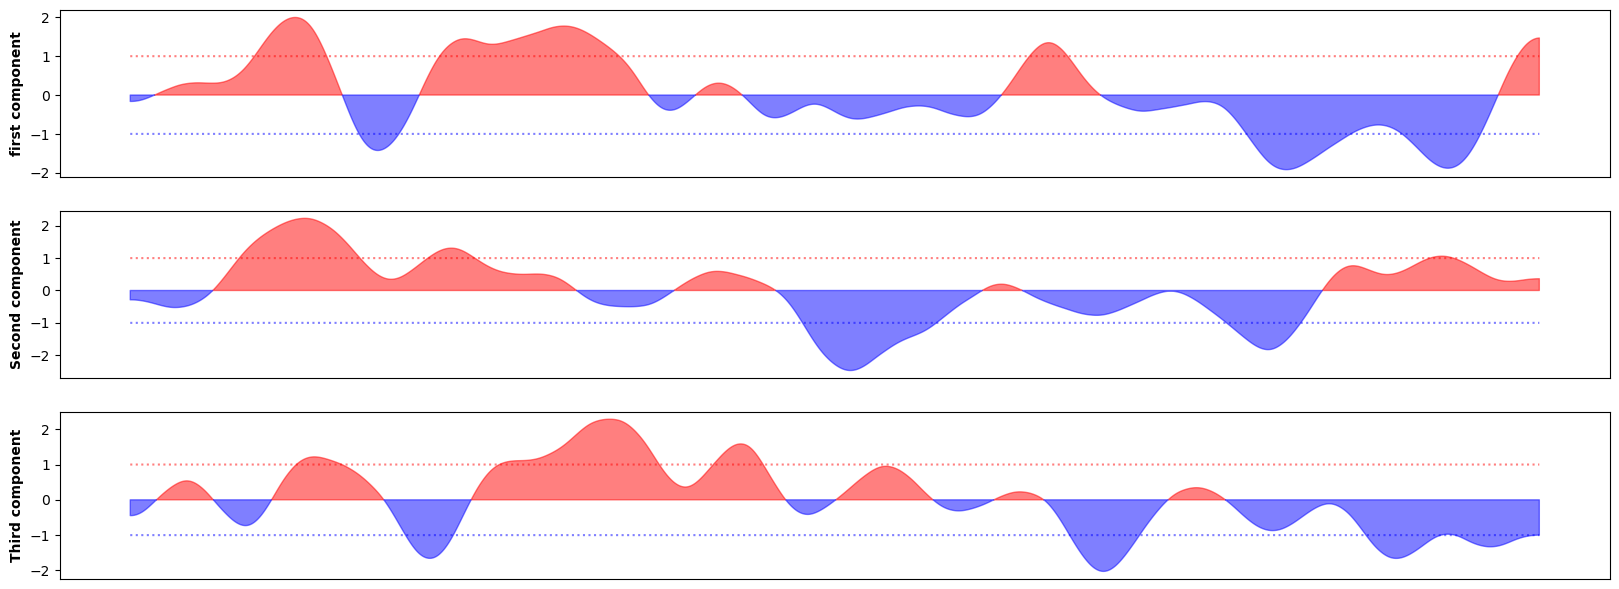

In [14]:
# plota series dos indices feitos com OS INDICES:
m=0

# NINO
plt.figure()
fig = plt.figure(figsize=(20,5*2))#

a= fig.add_subplot(4, 1,1)
PlotSeries(a, proj1[m],
           label_pos='positive',label_neg='negative',
           Title='first component',start = 0)

# AMM
a= fig.add_subplot(4, 1,2)
PlotSeries(a, proj2[m],
           label_pos='positive',label_neg='negative',
           Title='Second component',start = 0)

# SASD
a= fig.add_subplot(4, 1,3)
PlotSeries(a, proj3[m],
           label_pos='positive',label_neg='negative',
           Title='Third component',start = 0)

# Clusters
#a= fig.add_subplot(4, 1,4)
#PlotSeries_c(a, cluster_ppt[m],Title='clusters')

<Figure size 640x480 with 0 Axes>

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


<Figure size 640x480 with 0 Axes>

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


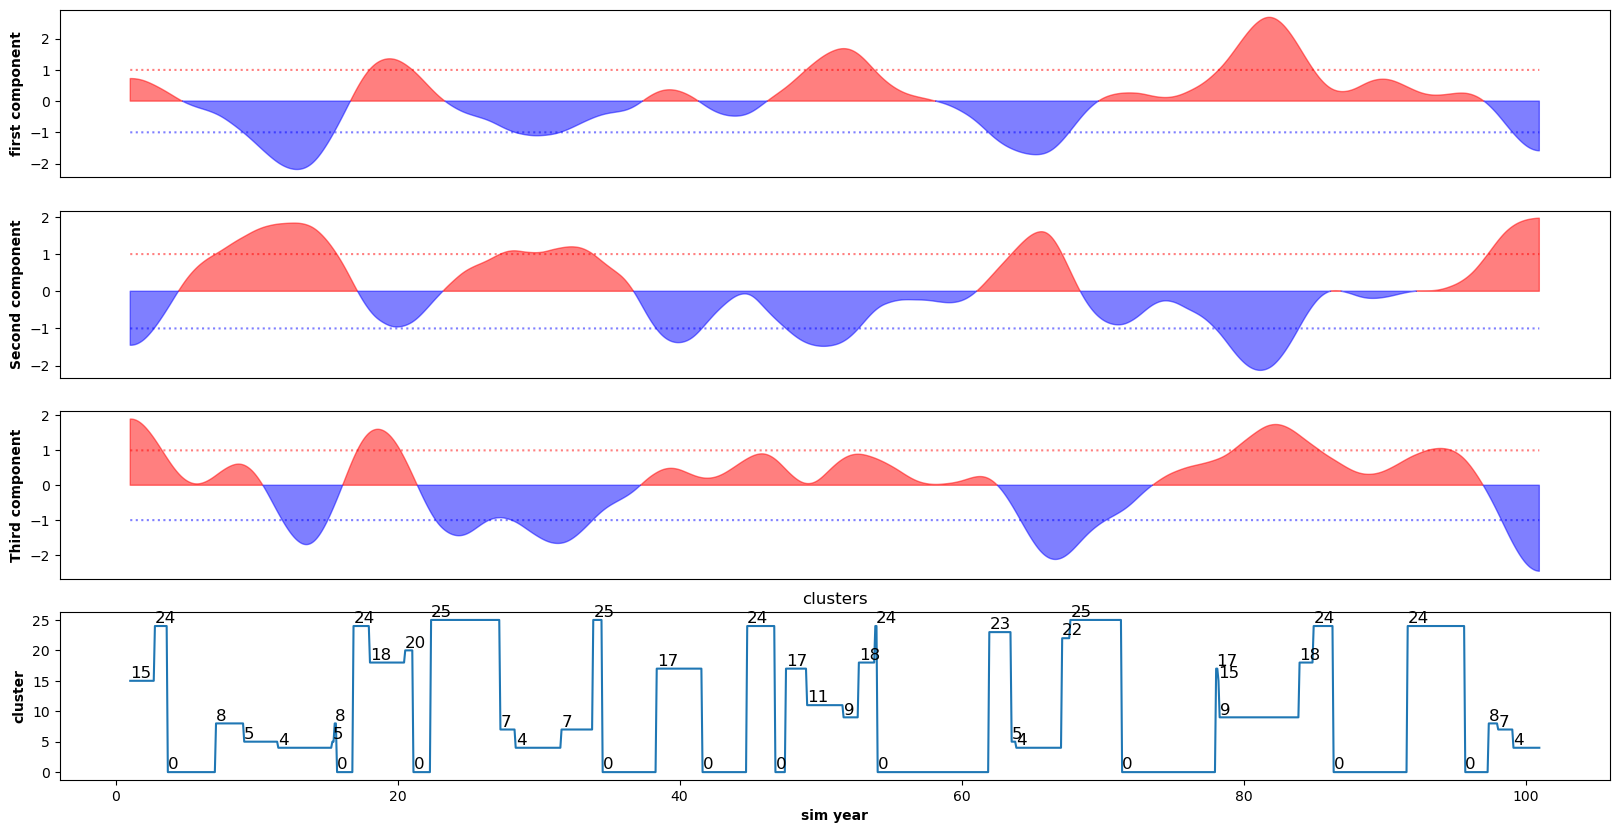

In [644]:
# plota series dos indices feitos com OS INDICES:
m=0

# NINO
plt.figure()
fig = plt.figure(figsize=(20,5*2))#

a= fig.add_subplot(4, 1,1)
PlotSeries(a, AMMS[m],
           label_pos='positive',label_neg='negative',
           Title='first component',start = 0)

# AMM
a= fig.add_subplot(4, 1,2)
PlotSeries(a, NINOS[m],
           label_pos='positive',label_neg='negative',
           Title='Second component',start = 0)

# SASD
a= fig.add_subplot(4, 1,3)
PlotSeries(a, SASDS[m],
           label_pos='positive',label_neg='negative',
           Title='Third component',start = 0)

# Clusters
a= fig.add_subplot(4, 1,4)
PlotSeries_c(a, cluster_sst[m],Title='clusters')

In [15]:
## salva EOFs

np.save('SST_eof1.npy',proj1)
np.save('SST_eof2.npy',proj2)
np.save('SST_eof3.npy',proj3)

#### PCA PPT - AGORA COM LATITUDES REFERENTES A EOF - tropical e subtropical

In [16]:
Vppta.shape

(20400, 80, 89)

In [17]:
# clusteriza PPT dos modelos de acordo com decomposição de PCA
# Vetor dados
vetor = Vppta # Vppta, Vtosa
X = vetor.reshape((vetor.shape[0],vetor.shape[1]*vetor.shape[2]))
X = X[:, ~np.isnan(X).any(axis=0)] # tira valores nan
X = np.swapaxes(X,0,1) # X é lat*lon, tempo
#print(Vtosa.shape,X.shape,Vnino.shape)
#print(np.count_nonzero(np.isnan(X)))

In [18]:
### Full PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
expl = pca.explained_variance_ratio_
svalues = pca.singular_values_
xx = pca.transform(X)

In [19]:
xx =  np.swapaxes(xx,0,1)
xx = xx.reshape(xx.shape[0],vetor.shape[1],vetor.shape[2]) # componentes, lat,lon

90%% dos dados são explicados com as 99 componentes.


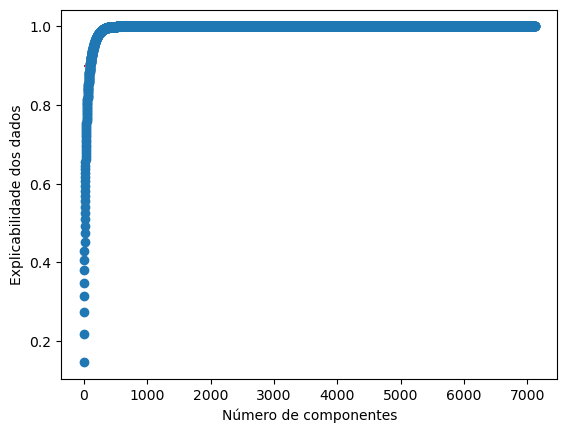

In [20]:
ax = plt.figure().gca()
#...

explainability = pca.explained_variance_ratio_.cumsum()
factors = np.arange(1,X.shape[0]+1,1)

plt.scatter(factors,explainability)
plt.hlines(0.9,0,20,'r')
plt.xlabel('Número de componentes')
plt.ylabel('Explicabilidade dos dados')
#ax.set_xticks([2,3,4,5,6,7,8,9])

p = factors[explainability<0.9].max()+1
if p<2:
    p=2

print('90%% dos dados são explicados com as ' + str(p) + ' componentes.')

In [21]:
# ESCOLHE APENAS AS 3 PRIMEIRAS COMPONENTES
p=3

pca = PCA(n_components=p)
pca.fit(X)
x = pca.transform(X)
x = x[:,0:p]
print(x.shape)
x =  np.swapaxes(x,0,1)
x = x.reshape(x.shape[0],vetor.shape[1],vetor.shape[2]) # componentes, lat,lon

(7120, 3)


locator: <matplotlib.ticker.FixedLocator object at 0x7efffb483b50>
locator: <matplotlib.ticker.FixedLocator object at 0x7f0040a423e0>
locator: <matplotlib.ticker.FixedLocator object at 0x7efe0de194e0>


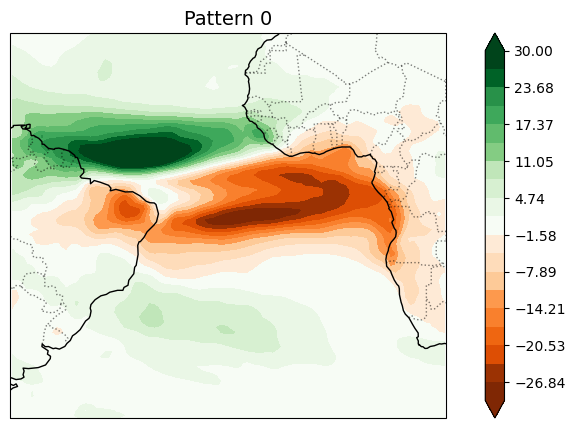

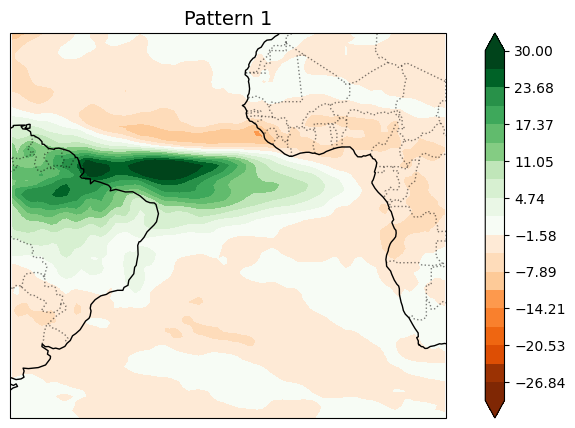

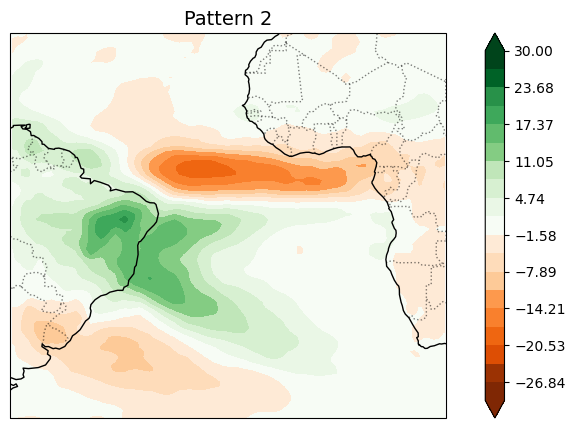

In [22]:
for pattern in [0,1,2]:
    plot = np.squeeze(x[pattern]).reshape(len(lat),len(lon))

    levelppt = 30
    levelp = np.linspace(-levelppt,levelppt, 20)
    levelsst = 30
    levels = np.linspace(-levelsst,levelsst, 20)

    ### CMAP PARA CHUVA ############################
    top = cm.get_cmap('Greens', 12)
    bottom = cm.get_cmap('Oranges_r', 12)
    newcolors = np.vstack((bottom(np.linspace(0, 1, 12)),
                           top(np.linspace(0, 1, 12))))
    cmpchuva = ListedColormap(newcolors, name='OrangeGreen')
    ################################################

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1, aspect='equal',
                         projection=ccrs.PlateCarree(central_longitude=-90.0, globe=None))

    ax.set_extent([-65, 24, -49, 29.5], ccrs.PlateCarree())
    im = ax.contourf(lon, lat, plot,levels=levelp,cmap=cmpchuva,extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'         
    ax.coastlines(linewidths=1)
    ax.add_feature(cf.BORDERS, linestyle=':', alpha=.5)

    ax.set_title('Pattern '+ str(pattern), fontsize=14)
    plt.colorbar(im)

In [23]:
# projeta mapas ppta do atlantico nas 3 componentes principais (x), criando indice de cada componente

proj1, proj2, proj3 = copy.deepcopy(NINOS),copy.deepcopy(NINOS),copy.deepcopy(NINOS)
counter = -1
m=-1

for model in lista1200:
    m+=1
    counter = -1
    for ppt in Mppta[model][:1200]:
        counter+=1
        ppt = ppt.reshape(ppt.shape[0]*ppt.shape[1])
        first = np.squeeze(x[0]).reshape(ppt.shape[0])
        second = np.squeeze(x[1]).reshape(ppt.shape[0])
        third = np.squeeze(x[2]).reshape(ppt.shape[0])

        proj1[m][counter] = np.inner(ppt,first)
        proj2[m][counter] = np.inner(ppt,second)
        proj3[m][counter] = np.inner(ppt,third)

    # divide pelo desvio padrao
    proj1[m] = proj1[m]/np.std(proj1[m])
    proj2[m] = proj2[m]/np.std(proj2[m])
    proj3[m] = proj3[m]/np.std(proj3[m])


In [24]:
## salva EOFs

np.save('PPT_eof1.npy',proj1)
np.save('PPT_eof2.npy',proj2)
np.save('PPT_eof3.npy',proj3)

# GMD SCRIPTS

In [30]:
proj1_s = np.load('SST_eof1.npy')
proj2_s = np.load('SST_eof2.npy')
proj3_s = np.load('SST_eof3.npy')

proj1_p = np.load('PPT_eof1.npy')
proj2_p = np.load('PPT_eof2.npy')
proj3_p = np.load('PPT_eof3.npy')

## Trajectories in Phase Space

In [31]:
# CLUSTERIZA DE ACORDO COM COMPONENTES do PCA
def clusteriza3d(proj1,proj2,proj3,limite1=1,limite2=1,limite=1):
    # clusteriza sistema tri-dimensional em 27 clusters
    # a partir do limite estabelecido para as series de indices proj1,proj2,proj3
    
    cluster = []
    
    for nino,amm,sasd in zip(proj1,proj2,proj3):
        
        nino,amm,sasd = nino/np.std(nino),amm/np.std(amm),sasd/np.std(sasd)
        cluster_series = np.zeros(nino.shape[0])
        for t in range(len(nino)):
            if nino[t] > limite1: # NINO pos
                if amm[t] > limite2: # AMM pos
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=26
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=1
                    else: # SASD neutro
                        cluster_series[t]=2
                elif amm[t] < -limite2: # AMM neg
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=3
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=4
                    else: # SASD neutro
                        cluster_series[t]=5
                else: # AMM neutro
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=6
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=7
                    else: # SASD neutro
                        cluster_series[t]=8

            elif nino[t] < -limite1: # Nino neg
                if amm[t] > limite2: # AMM pos
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=9
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=10
                    else: # SASD neutro
                        cluster_series[t]=11
                elif amm[t] < -limite2: # AMM neg
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=12
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=13
                    else: # SASD neutro
                        cluster_series[t]=14
                else: # AMM neutro
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=15
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=16
                    else: # SASD neutro
                        cluster_series[t]=17

            else: # Nino neutro
                if amm[t] > limite2: # AMM pos
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=18
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=19
                    else: # SASD neutro
                        cluster_series[t]=20
                elif amm[t] < -limite2: # AMM neg
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=21
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=22
                    else: # SASD neutro
                        cluster_series[t]=23
                else: # AMM neutro
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=24
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=25
                    else: # SASD neutro
                        cluster_series[t]=0
        cluster.append(cluster_series)                
    return cluster

# CLUSTERIZA DE ACORDO COM COMPONENTES do PCA
def clusteriza1d(proj1,proj2,proj3,limite=1,):
    # clusteriza sistema tri-dimensional em 27 clusters
    # a partir do limite estabelecido para as series de indices proj1,proj2,proj3
    
    cluster = []
    
    for nino,amm,sasd in zip(proj1,proj2,proj3):
        
        nino,amm,sasd = nino/np.std(nino),amm/np.std(amm),sasd/np.std(sasd)
        cluster_series = np.zeros(nino.shape[0])
        for t in range(len(nino)):
            if nino[t] > limite: # NINO pos
                if amm[t] > limite: # AMM pos
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=26
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=1
                    else: # SASD neutro
                        cluster_series[t]=2
                elif amm[t] < -limite: # AMM neg
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=3
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=4
                    else: # SASD neutro
                        cluster_series[t]=5
                else: # AMM neutro
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=6
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=7
                    else: # SASD neutro
                        cluster_series[t]=8

            elif nino[t] < -limite: # Nino neg
                if amm[t] > limite: # AMM pos
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=9
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=10
                    else: # SASD neutro
                        cluster_series[t]=11
                elif amm[t] < -limite: # AMM neg
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=12
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=13
                    else: # SASD neutro
                        cluster_series[t]=14
                else: # AMM neutro
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=15
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=16
                    else: # SASD neutro
                        cluster_series[t]=17

            else: # Nino neutro
                if amm[t] > limite: # AMM pos
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=18
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=19
                    else: # SASD neutro
                        cluster_series[t]=20
                elif amm[t] < -limite: # AMM neg
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=21
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=22
                    else: # SASD neutro
                        cluster_series[t]=23
                else: # AMM neutro
                    if sasd[t] > limite: # SASD pos
                        cluster_series[t]=24
                    elif sasd[t] < -limite: # SASD neg
                        cluster_series[t]=25
                    else: # SASD neutro
                        cluster_series[t]=0
        cluster.append(cluster_series)                
    return cluster

In [32]:
cluster_ppt = clusteriza3d(proj1_p,proj2_p,proj3_p,limite=0.5)
cluster_sst = clusteriza3d(proj1_s,proj2_s,proj3_s,limite=0.5)

#cluster_test = clusteriza3d(NINOS,AMMS,proj3,limite=0.75)

## Print Indexes and System States

In [33]:
def PlotSeries(fig, series, color_pos='r',color_neg='b',label_pos=None,label_neg=None,Title=None,start = 0):
    # FUNCAO QUE PLOTA SERIES
    
    #### Linhas constantes de +1 e -1 #
    xx=list(range(0, len(series)))
    x=copy.deepcopy(xx)
    for i in range(len(xx)):
        x[i]=1+(0.5+xx[i])/12
    y=[1]*len(x)
    yy=[-1]*len(x)
    ###################################
    
    plt.fill_between(x, series,
                     where=(series > 0),
                     alpha=0.50, color=color_pos, interpolate=True, label=label_pos)
    plt.fill_between(x, series,
                     where=(series < 0),
                     alpha=0.50, color=color_neg, interpolate=True, label=label_neg)
    
    #fig.title.set_text(Title)
    fig.set_ylabel(Title,fontweight ='bold')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    plt.plot(x[start:len(x)],y[start:len(x)],linestyle=":",color=color_pos,alpha=0.5)
    plt.plot(x[start:len(x)],yy[start:len(x)],linestyle=":",color=color_neg,alpha=0.5)
 
import pylab as pl

def PlotSeries_c(fig, clusters,Title=None,start = 0):
    
    #### Linhas constantes de +1 e -1 #
    xx=list(range(0, len(clusters)))
    x=copy.deepcopy(xx)
    for i in range(len(xx)):
        x[i]=1+(0.5+xx[i])/12
    y=[1]*len(x)
    yy=[-1]*len(x)
    ###################################
    
    fig.title.set_text(Title)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        #bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off
    )

    pl.plot(x, clusters, "")
    antigo =-1
    for xs, cs in zip(x, clusters):
        if antigo != cs:
            pl.text(xs, cs+0.5 , str(int(cs)), color="k", fontsize=12)
            antigo = cs
        else:
            antigo = cs
    fig.set_ylabel('cluster',fontweight ='bold')
    fig.set_xlabel('sim year',fontweight ='bold')
    

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


<Figure size 640x480 with 0 Axes>

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


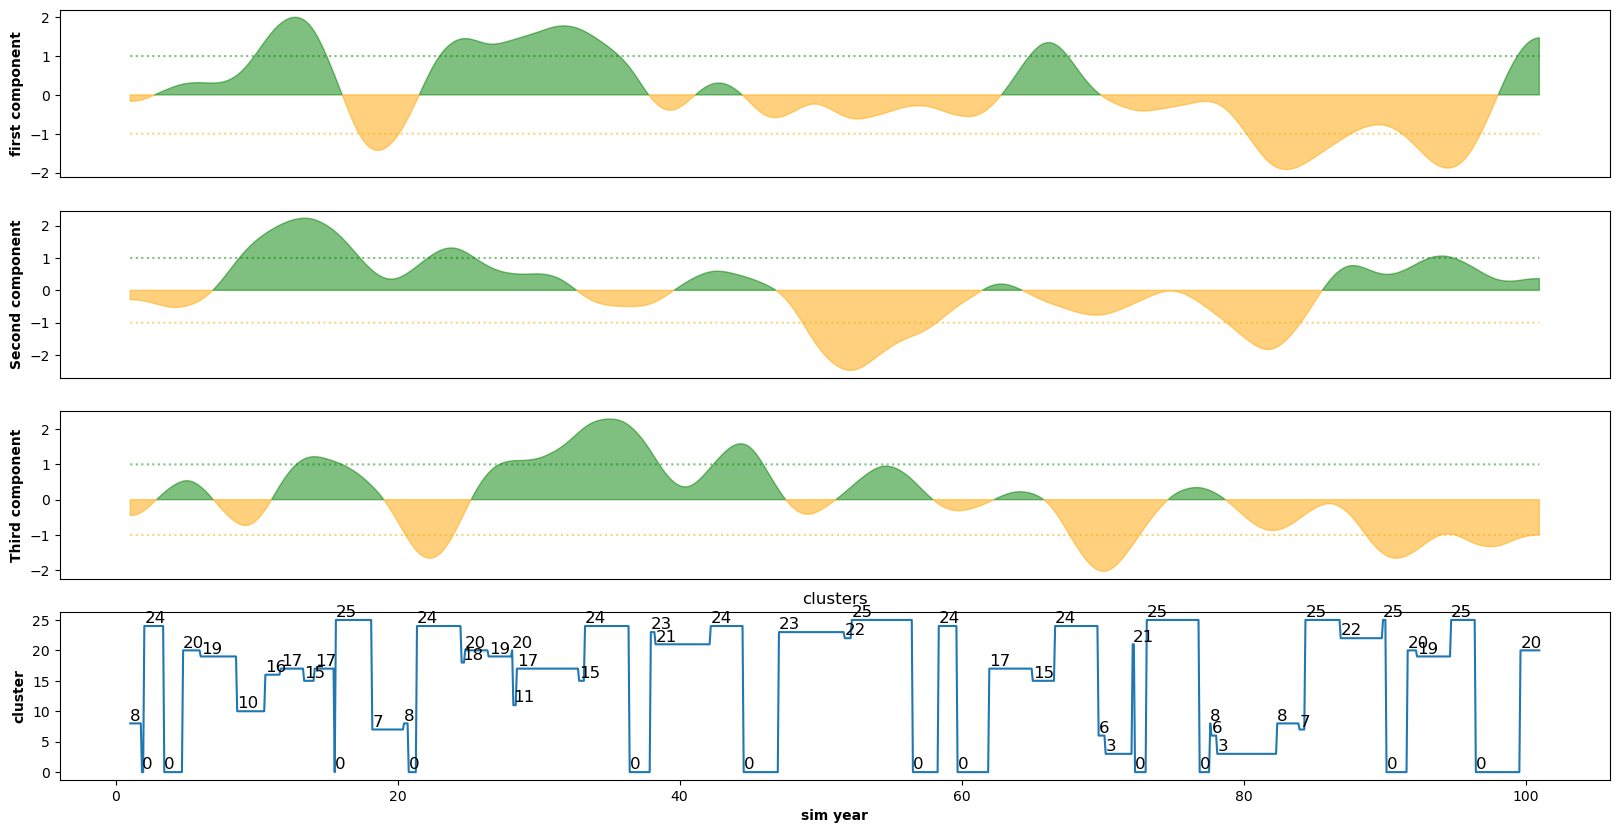

In [35]:
# plota series dos indices feitos com as projecoes:
m=0

# NINO
plt.figure()
fig = plt.figure(figsize=(20,5*2))#

a= fig.add_subplot(4, 1,1)
PlotSeries(a, proj1_s[m],color_pos='green',color_neg='orange',
           label_pos='positive',label_neg='negative',
           Title='first component',start = 0)

# AMM
a= fig.add_subplot(4, 1,2)
PlotSeries(a, proj2_s[m],color_pos='green',color_neg='orange',
           label_pos='positive',label_neg='negative',
           Title='Second component',start = 0)

# SASD
a= fig.add_subplot(4, 1,3)
PlotSeries(a, proj3_s[m],color_pos='green',color_neg='orange',
           label_pos='positive',label_neg='negative',
           Title='Third component',start = 0)

# Clusters

a= fig.add_subplot(4, 1,4)
PlotSeries_c(a, cluster_ppt[m],Title='clusters')

## GRAPHS

In [36]:
# Compute Graphs and Sizes of nodes

import collections

Ccyclesst=[]
Ccycleppt=[]
sizesst=[]
sizeppt=[]

lista=[]
for m in range(len(cluster_sst)):
    c_atual = -1
    dic={}
    for t in range(len(cluster_sst[m])):
        c=int(cluster_sst[m][t])
        if (c in dic):
            dic[c] += 1
        else:
            dic[c] = 1
        if c != c_atual:
            c_atual=c
            lista.append(c)
    sizesst.append(dic)
    Ccyclesst.append(lista)
    lista=[]

    

for m in range(len(cluster_ppt)):
    c_atual = -1
    dic={}
    for t in range(len(cluster_ppt[m])):
        c=int(cluster_ppt[m][t])
        if (c in dic):
            dic[c] += 1
        else:
            dic[c] = 1
        if c != c_atual:
            c_atual=c
            lista.append(c)
    sizeppt.append(dic)
    Ccycleppt.append(lista)
    lista=[]
    
# Soma de sizes em cenário de união das forçantes ##########################3
PI=[0,9,12,16]
MH=[2,8,11,15]


results = {}
for d in [sizesst[2],sizesst[8],sizesst[11],sizesst[15]]:
    for k in d.keys():
        results[k] = results.get(k, 0) + d[k]
resultp = {}
for d in [sizesst[2],sizesst[8],sizesst[11],sizesst[15]]:
    for k in d.keys():
        resultp[k] = resultp.get(k, 0) + d[k]
sizesst_MH=dict(results)
sizeppt_MH=dict(resultp)
    
results = {}
for d in [sizesst[0],sizesst[9],sizesst[12],sizesst[16]]:
    for k in d.keys():
        results[k] = results.get(k, 0) + d[k]
resultp = {}
for d in [sizesst[0],sizesst[9],sizesst[12],sizesst[16]]:
    for k in d.keys():
        resultp[k] = resultp.get(k, 0) + d[k]
sizesst_PI=dict(results)
sizeppt_PI=dict(resultp)

In [37]:
# Compute weights and Conection between nodes

modelo=Ccyclesst

## CONTA NUMERO DE VEZES QUE UM CLUSTER EVOLUI PARA OUTRO (CONTA IDA E VOLTA COMO UMA COISA SÓ)
## MEDE A LIGACAO ENTRE OS CLUSTERS
pesos=[]
pesoligs=[]
for m in range(len(modelo)):
    dic={}
    for i in range(len(modelo[m])-1): # calcula total de vezes que um modelo passou para outro
        if modelo[m][i] in dic:     # ou seja, ele reflete a porcentagem de vezes que um cluster passou para outro
            dic[modelo[m][i]] +=1
        else:
            dic[modelo[m][i]] =1
    pesos.append(dic)
    
    dic2={}
    for i in range(1,len(modelo[m])):
        if str(modelo[m][i-1])+str(modelo[m][i]) in dic2:
            dic2[str(modelo[m][i-1])+str(modelo[m][i])] += 1/dic[modelo[m][i-1]]
        else:
            dic2[str(modelo[m][i-1])+str(modelo[m][i])] = 1/dic[modelo[m][i-1]]
    pesoligs.append(dic2)
    
modelo=Ccycleppt

## CONTA NUMERO DE VEZES QUE UM CLUSTER EVOLUI PARA OUTRO (CONTA IDA E VOLTA COMO UMA COISA SÓ)
## MEDE A LIGACAO ENTRE OS CLUSTERS
pesop=[]
pesoligp=[]
for m in range(len(modelo)):
    dic={}
    for i in range(len(modelo[m])-1): # calcula total de vezes que um modelo passou para outro
        if modelo[m][i] in dic:     # ou seja, ele reflete a porcentagem de vezes que um cluster passou para outro
            dic[modelo[m][i]] +=1
        else:
            dic[modelo[m][i]] =1
    pesop.append(dic)
    
    dic2={}
    for i in range(1,len(modelo[m])):
        if str(modelo[m][i-1])+str(modelo[m][i]) in dic2:
            dic2[str(modelo[m][i-1])+str(modelo[m][i])] += 1/dic[modelo[m][i-1]]
        else:
            dic2[str(modelo[m][i-1])+str(modelo[m][i])] = 1/dic[modelo[m][i-1]]
    pesoligp.append(dic2)

In [42]:
model = 0
print("SST")
for c,p,s in zip(pesos[model].keys(),pesos[model].values(),sizesst[model].values()):
    print('cluster: ',c, '/ n_arestas :', p, '/ meses no cluster(size): ',s)
    
print("PPT") 
for c,p,s in zip(pesop[model].keys(),pesop[model].values(),sizeppt[model].values()):
    print('cluster: ',c, '/ n_arestas :', p, '/ meses no cluster(size): ',s)

SST
cluster:  0 / n_arestas : 7 / meses no cluster(size):  261
cluster:  24 / n_arestas : 3 / meses no cluster(size):  123
cluster:  25 / n_arestas : 5 / meses no cluster(size):  179
cluster:  19 / n_arestas : 2 / meses no cluster(size):  23
cluster:  1 / n_arestas : 2 / meses no cluster(size):  23
cluster:  2 / n_arestas : 2 / meses no cluster(size):  31
cluster:  26 / n_arestas : 1 / meses no cluster(size):  38
cluster:  18 / n_arestas : 1 / meses no cluster(size):  27
cluster:  9 / n_arestas : 1 / meses no cluster(size):  1
cluster:  15 / n_arestas : 1 / meses no cluster(size):  7
cluster:  17 / n_arestas : 2 / meses no cluster(size):  65
cluster:  16 / n_arestas : 4 / meses no cluster(size):  51
cluster:  8 / n_arestas : 2 / meses no cluster(size):  30
cluster:  6 / n_arestas : 1 / meses no cluster(size):  118
cluster:  23 / n_arestas : 3 / meses no cluster(size):  82
cluster:  21 / n_arestas : 1 / meses no cluster(size):  49
cluster:  7 / n_arestas : 1 / meses no cluster(size):  2

In [43]:
import networkx as nx

## CRIA LISTA COM DIRECTED GRAPHS DOS CICLOS DE CLUSTERS DE SST
modelo = Ccyclesst

# create an empty undirected graph
Gs=[]
#position=[(3,0.5),(.5,0),(2.5,0),(2.5,1.5),(0,0.5),(0.5,1.5),(2,0.5),(1.5,0),(1.5,1.5)]
for m in range(len(modelo)):
    DG = nx.DiGraph()
    for c in pesos[m].keys():
        DG.add_node(c) # ,pos=position[c]) # posição pre-definida
    dic={}
    for i in range(1,len(modelo[m])):
        A=modelo[m][i-1]
        B=modelo[m][i]
        if str(A)+str(B) in dic:
            a=0
        else:
            pes="{:.2f}".format(pesoligs[m][str(A)+str(B)])
            DG.add_edge(A,B,weight = pes)
            dic[str(A)+str(B)]=1
    Gs.append(DG)


for m in range(len(Gs)):
    for i in list(Gs[m].nodes()):
        try:
            Gs[m].nodes[i]['size'] = sizesst[m][i]
        except:
            Gs[m].nodes[i]['size']=0
        
## CRIA LISTA COM DIRECTED GRAPHS DOS CICLOS DE CLUSTERS DE PPT
modelo = Ccycleppt

# create an empty undirected graph
Gp=[]
#position=[(3,0.5),(.5,0),(2.5,0),(2.5,1.5),(0,0.5),(0.5,1.5),(2,0.5),(1.5,0),(1.5,1.5)]
for m in range(len(modelo)):
    DG = nx.DiGraph()
    for c in pesop[m].keys():
        DG.add_node(c) # ,pos=position[c]) # posição pre-definida
    dic={}
    for i in range(1,len(modelo[m])):
        A=modelo[m][i-1]
        B=modelo[m][i]
        if str(A)+str(B) in dic:
            a=0
        else:
            pes="{:.2f}".format(pesoligp[m][str(A)+str(B)])
            DG.add_edge(A,B,weight = pes)
            dic[str(A)+str(B)]=1
    Gp.append(DG)


for m in range(len(Gp)):
    for i in list(Gp[m].nodes()):
        try:
            Gp[m].nodes[i]['size'] = sizeppt[m][i]
        except:
            Gp[m].nodes[i]['size']=0
            
#print("Total number of nodes: ", int(G[m].number_of_nodes()))
#print("Total number of edges: ", int(G[0].number_of_edges()))
#print("List of all nodes: ", list(G[m].nodes()))
#print("List of all edges: ", list(G[m].edges(data = True)))
#print("Degree for all nodes: ", dict(G[m].degree())) 
#print("Total number of self-loops: ", int(G[m].number_of_selfloops()))
#print("List of all nodes with self-loops: ",
#             list(G[m].nodes_with_selfloops()))

#print("List of all nodes we can go to in a single step from node 2: ",
#                                                 list(G[m].neighbors(2)))

top of Axes not in the figure, so title not moved


[2, 5, 7, 2, 3, 10, 6, 2, 5, 2, 2, 2, 4, 4, 4, 2, 2, 2]


top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


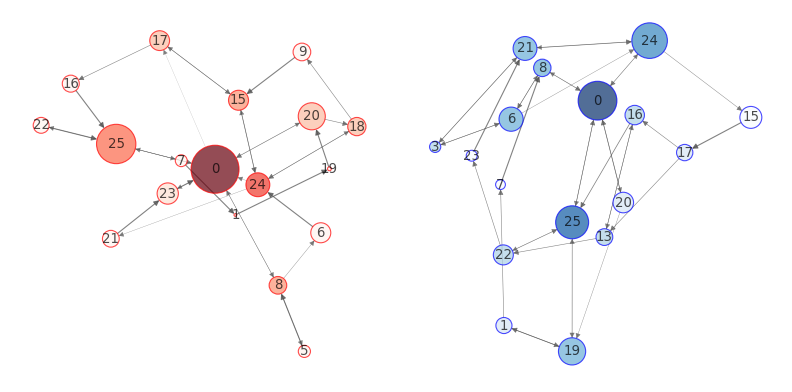

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


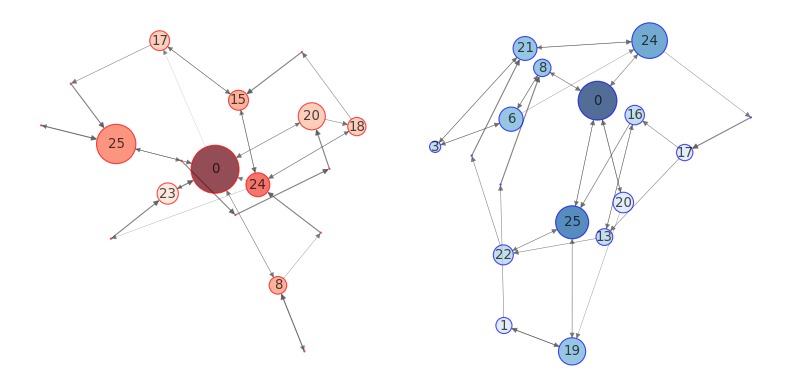

In [44]:

## ## ## ## ## ## ## ## ## 
## PLOT DE GRAPHO INDIVIDUAL ##
  ## ## ## ## ## ## ## ## ## 

    ## MODEL        -  MODEL number #
    # ECE:B405 PI   -       0       #       
    # ECE:Z6KA MH   -       1       # 
    # ECE:G105 GS   -       2       # 
    # ECE:G506 GSrd -       3       # 
               
    # GIS:GSALLK    -       4       # 
    # GIS:GSALLN    -       5       # 
    # GIS:GSEx      -       6       # 
    # GIS:GSNA      -       7       # 
    # GIS:MH        -       8       # 
    # GIS:PI        -       9       # 
    #                               # 
    # iCESM:GS      -       10      # 
    # iCESM:MH      -       11      # 
    # iCESM:PI      -       12      # 
    #                               #                                            
    # Toronto:GS    -       13      #       
    # Toronto:GSsl  -       14      #             
    # Toronto:MH    -       15      #           
    # Toronto:PI    -       16      #  
    #################################

i=0 #modelo    

#for i in range(len(Gs)):
plt.figure(figsize=(10, 5), dpi=80)

## SST ##
node_size=[]
node_color = [Gs[i].degree(v) for v in Gs[i]]
#node_color.pop()
#node_color.append(4)
print(node_color)
node_size = [6* nx.get_node_attributes(Gs[i], 'size')[v] for v in Gs[i]]        
edge_width = [ Gs[i][u][v]['weight'] for u, v in Gs[i].edges()]

# posição fixa
pos = nx.spring_layout(Gs[i])

subax1 = plt.subplot(1,2,1)

cmap=plt.cm.Reds
edgecolor="red"

nx.draw_networkx(Gs[i], node_size = node_size, 
                node_color = node_color, alpha = 0.7,# labels=labeldict,
                with_labels = True, width = edge_width, pos=pos,
                edge_color = '.3', cmap = cmap)

ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor(edgecolor)
print(ax.collections[0])
b=plt.axis('off')
c=plt.tight_layout();

## PPT ##
node_size=[]
node_color = [Gp[i].degree(v) for v in Gp[i]]
#node_color.pop()
#node_color.append(4)
node_size = [6* nx.get_node_attributes(Gp[i], 'size')[v] for v in Gp[i]]
pop = nx.spring_layout(Gp[i])
edge_width = [ Gp[i][u][v]['weight'] for u, v in Gp[i].edges()]

cmap=plt.cm.Blues
edgecolor="blue"

subax2 = plt.subplot(1,2,2)

DRAWp=nx.draw_networkx(Gp[i], node_size = node_size, 
                node_color = node_color, alpha = 0.7,# labels=labeldict,
                with_labels = True, width = edge_width, pos=pop,
                edge_color ='.3', cmap = cmap)#,pos=pos)

ay = plt.gca() # to get the current axis
ay.collections[0].set_edgecolor(edgecolor)
b=plt.axis('off')
c=plt.tight_layout();

#for i in range(len(Gs)):
plt.figure(figsize=(10, 5), dpi=80)

## SST ##
node_size=[]
node_color = [Gs[i].degree(v) for v in Gs[i]]

### Tira nodes intermediários - graphos apenas com main nodes ##########

for v in Gs[i]:
    if Gs[i].degree(v)==2:
        node_size.append(1)
    else:
        node_size.append(6* nx.get_node_attributes(Gs[i], 'size')[v])    
# Tira numero dos nodes intermediários
labeldict = {}

for v in Gs[i].nodes:
    if Gs[i].degree(v)==2:
        labeldict[v] = ' '
    else:
        labeldict[v] = v
    ######################################################################
edge_width = [ Gs[i][u][v]['weight'] for u, v in Gs[i].edges()]

# posição fixa

subax1 = plt.subplot(1,2,1)

cmap=plt.cm.Reds
edgecolor="red"

nx.draw_networkx(Gs[i], node_size = node_size, 
                node_color = node_color, alpha = 0.7, labels=labeldict,
                with_labels = True, width = edge_width, pos=pos,
                edge_color ='.3', cmap = cmap)#,pos=pos)

ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor(edgecolor)
print(ax.collections[0])
b=plt.axis('off')
c=plt.tight_layout();

## PPT ##
node_size=[]
node_color = [Gp[i].degree(v) for v in Gp[i]]
#nodesize = [6* nx.get_node_attributes(Gp[i], 'size')[v] for v in Gp[i]]
### Tira nodes intermediários - graphos apenas com main nodes ##########
for v in Gp[i]:
    if Gp[i].degree(v)==2:
        node_size.append(1)
    else:
        node_size.append(6* nx.get_node_attributes(Gp[i], 'size')[v])
# Tira numero dos nodes intermediários
labeldict = {}


for v in Gp[i].nodes:
    if Gp[i].degree(v)==2:
        labeldict[v] = ' '
    else:
        labeldict[v] = v
    ######################################################################
edge_width = [ Gp[i][u][v]['weight'] for u, v in Gp[i].edges()]

cmap=plt.cm.Blues
edgecolor="blue"

subax2 = plt.subplot(1,2,2)

DRAWp=nx.draw_networkx(Gp[i], node_size = node_size, 
                node_color = node_color, alpha = 0.7, labels=labeldict,
                with_labels = True, width = edge_width, pos=pop,
                edge_color ='.3', cmap = cmap)#,pos=pos)

ay = plt.gca() # to get the current axis
ay.collections[0].set_edgecolor(edgecolor)
b=plt.axis('off')
c=plt.tight_layout();

In [45]:
## PLOTA O PADRAO pattern
def plot_pattern(pattern,size,model=0,modo = 'sst'):

    if model > 0:
        model+=1
    if model > 1:
        model+=1
    if model > 2:
        model+=1
    if model > 3:
        model+=1
        
    if modo == 'sst':
        CLUSTER = cluster_sst
        vetor = Mtosa[model][:1200]
    if modo == 'ppt':
        CLUSTER = cluster_ppt
        vetor = Mppta[model][:1200]

    # filtra padrao naquele modelo:
    #mask = np.zeros(len(CLUSTER[model]),dtype=bool)
    mask = (CLUSTER[model] == pattern)

    plot = np.nanmean(vetor[mask],axis=0)

    levelppt = 0.5
    levelp = np.linspace(-levelppt,levelppt, 20)
    levelsst = 0.5
    levels = np.linspace(-levelsst,levelsst, 20)

    ### CMAP PARA CHUVA ############################
    top = cm.get_cmap('Greens', 12)
    bottom = cm.get_cmap('Oranges_r', 12)
    newcolors = np.vstack((bottom(np.linspace(0, 1, 12)),
                           top(np.linspace(0, 1, 12))))
    cmpchuva = ListedColormap(newcolors, name='OrangeGreen')
    ################################################

    fig = plt.figure(figsize=(10,5))
    if modo == 'sst':
        ax = fig.add_subplot(1, 1, 1, aspect='equal',
                             projection=ccrs.PlateCarree(central_longitude=-90.0, globe=None))

        ax.set_extent([-65, 24, -49, 29.5], ccrs.PlateCarree())

        im = ax.contourf(lon, lat, plot,levels=levels,cmap="RdBu_r",extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'         
        ax.coastlines(linewidths=1)
        ax.add_feature(cf.BORDERS, linestyle=':', alpha=.5)


        # CHUVA #
         # # # #
        # # # # #
    elif modo == 'ppt':
        ax = fig.add_subplot(1, 1, 1, aspect='equal',
                             projection=ccrs.PlateCarree(central_longitude=-90.0, globe=None))

        ax.set_extent([-65, 24, -49, 29.5], ccrs.PlateCarree())
        im = ax.contourf(lon, lat, plot,levels=levelp,cmap=cmpchuva,extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'         
        ax.coastlines(linewidths=1)
        ax.add_feature(cf.BORDERS, linestyle=':', alpha=.5)

    ax.set_title('Pattern '+ str(pattern), fontsize=14)
    plt.colorbar(im)

/tmp/ipykernel_12152/242441736.py:24: RuntimeWarning: Mean of empty slice
  plot = np.nanmean(vetor[mask],axis=0)
locator: <matplotlib.ticker.FixedLocator object at 0x7efffaa2aa40>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffac701f0>
locator: <matplotlib.ticker.FixedLocator object at 0x7f0040add300>
locator: <matplotlib.ticker.FixedLocator object at 0x7f00409c9450>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffb480df0>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffa8b5c90>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffafa6da0>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffb4f77f0>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffa707190>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffa55b760>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffb0e4bb0>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffae83550>
locator: <matplotlib.ticker.FixedLocator object at 0x7efffaa2e7a0>
locator: <matpl

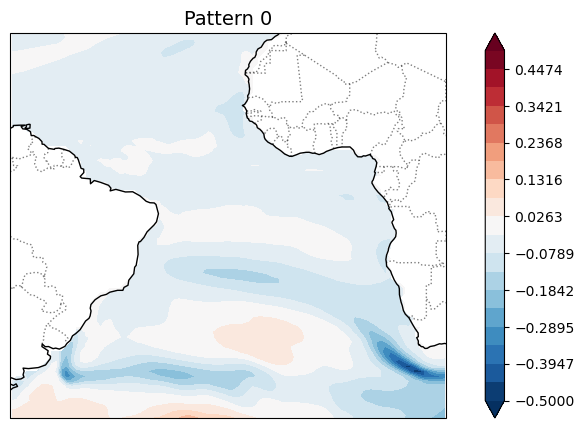

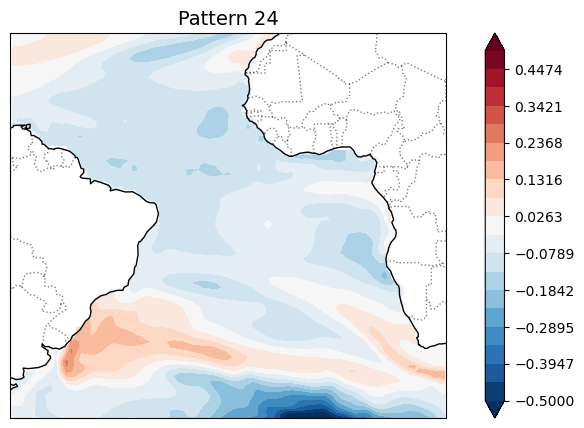

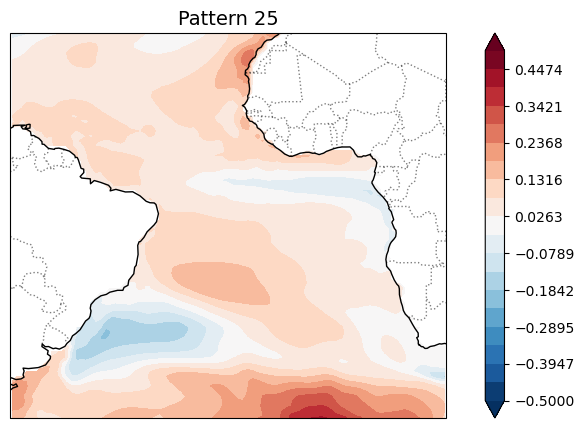

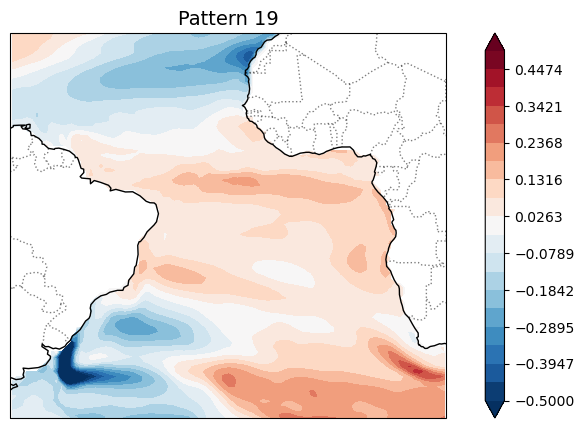

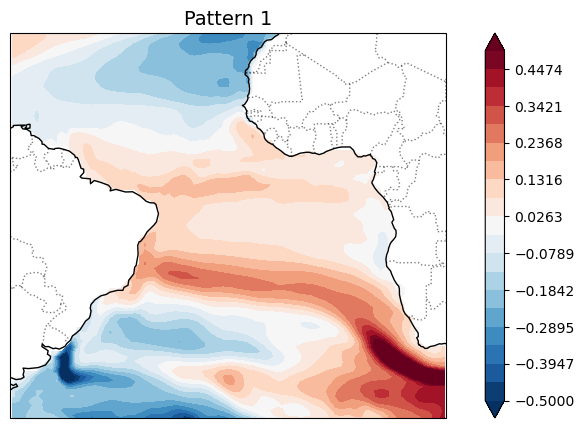

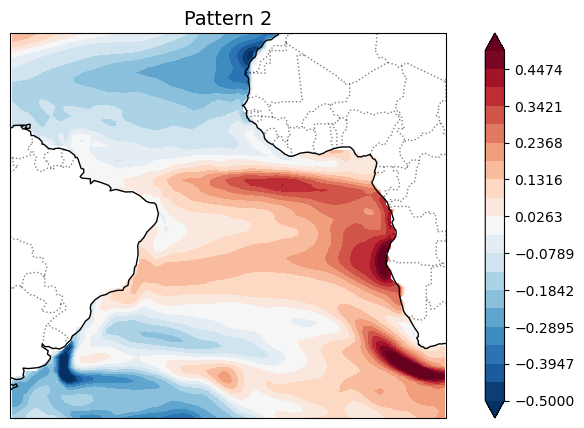

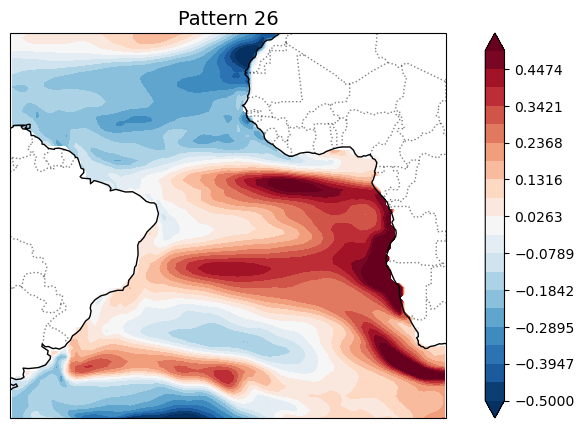

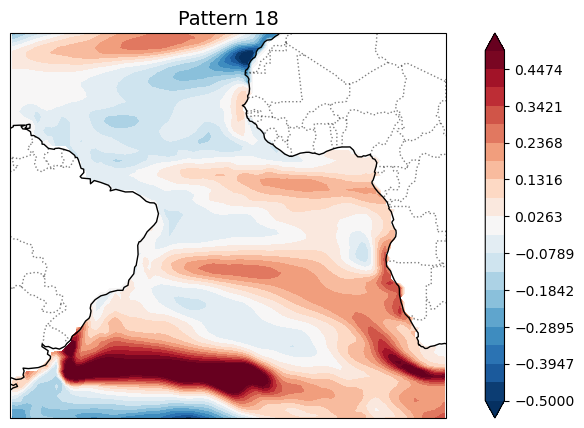

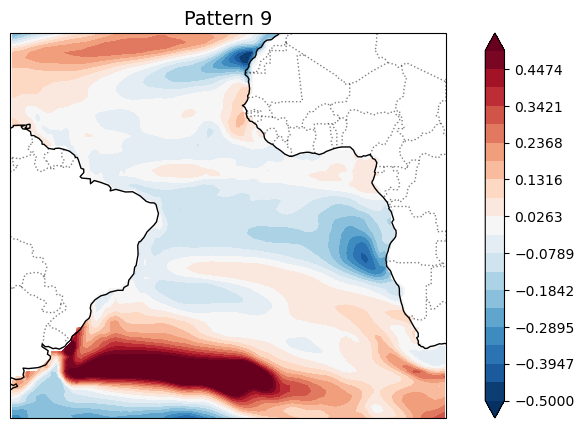

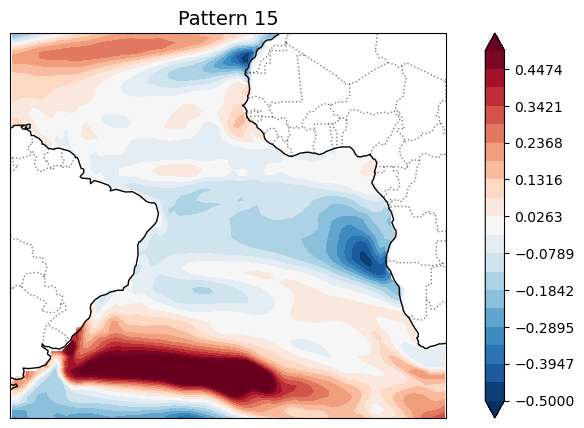

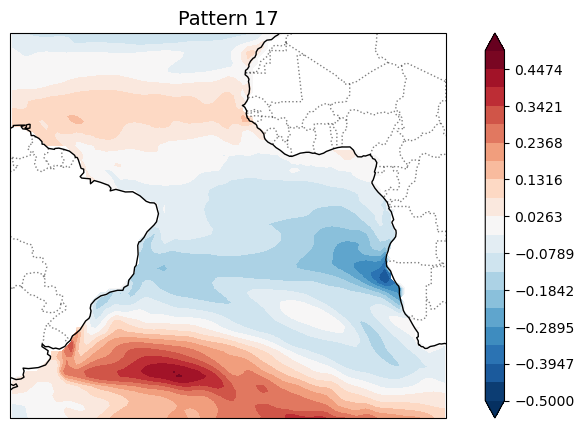

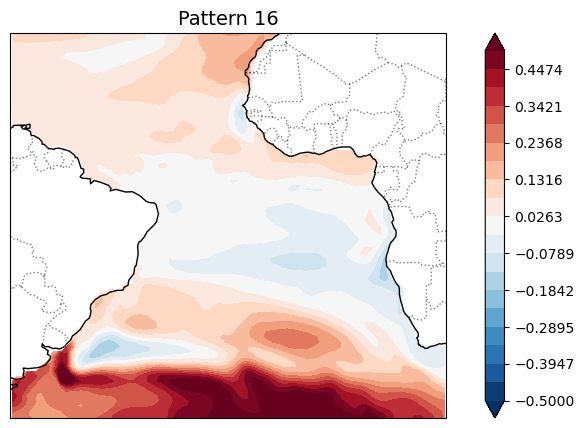

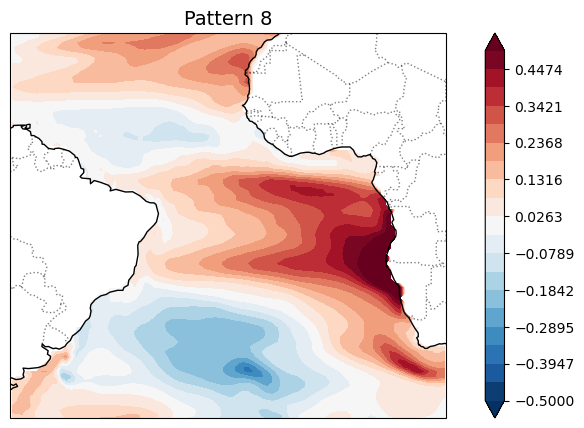

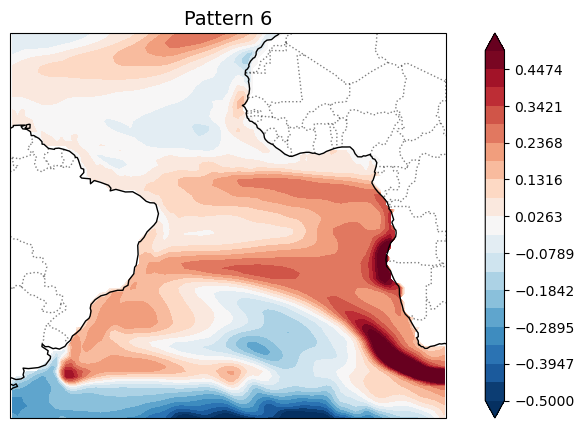

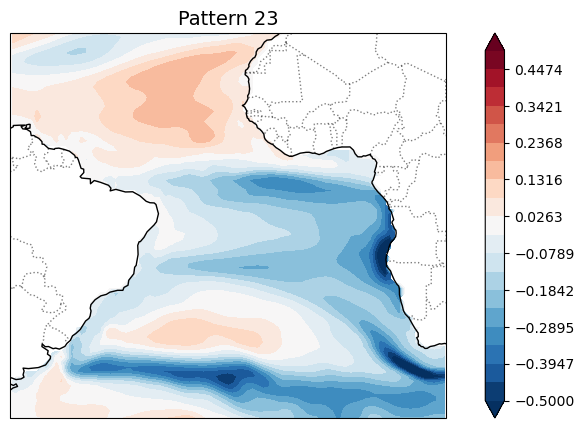

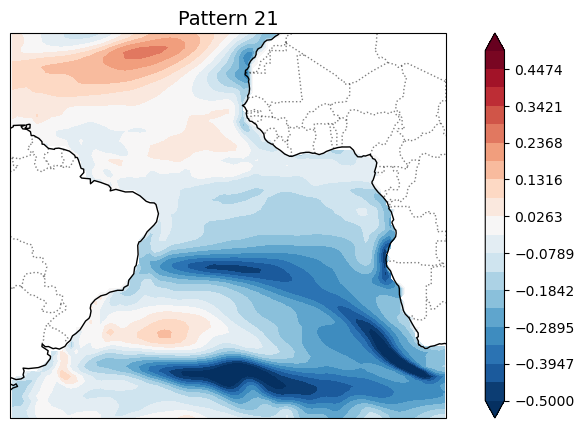

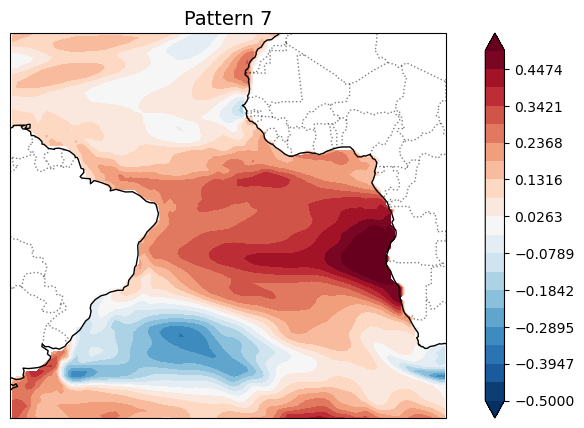

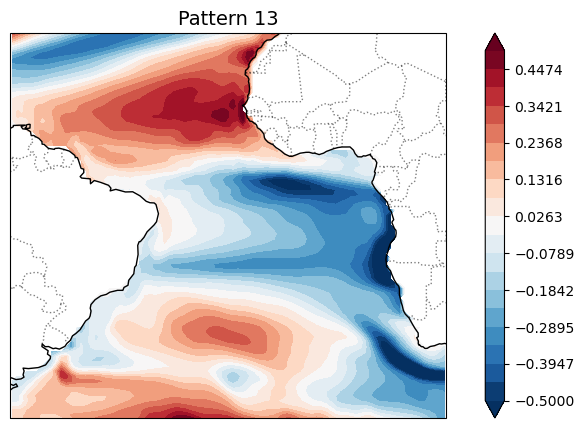

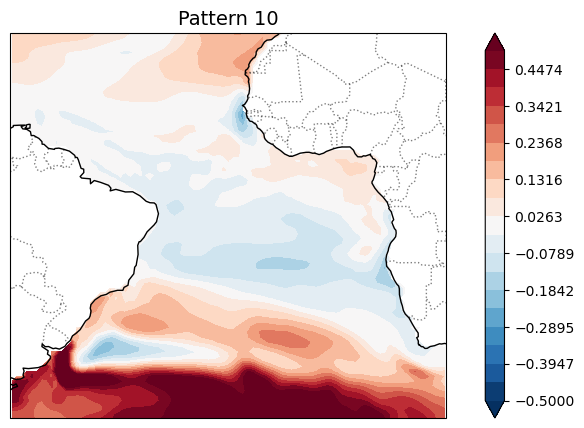

In [48]:
model = 0
modo = 'sst'

if modo == 'ppt':
    SIZE = sizeppt
elif modo == 'sst':
    SIZE = sizesst
    
for c,size in zip(SIZE[model].keys(),SIZE[model].values()):
    # imprime todos os clusters que aparecem no grapho
    plot_pattern(c,size,model=model,modo=modo)

## ENTROPIAS

In [49]:
# Calcula Entropias

def Entropia(Clusterseries):
    #calcula entropia de uma lista de dicionários (conjunto de vetores)
    
    #cria vetor que guarda entropia de cada serie temporal do Clusterseries
    Entropia = np.zeros(len(Clusterseries))
    
    # CONTA VALORES TOTAIS DE APARIÇÕES DE CADA ESTADO DO SISTEMA
    
    for m in range(len(Clusterseries)):
        dic={}
        size=len(Clusterseries[m])
        
        for val in Clusterseries[m]:
            if val in dic:
                dic[val]+=1
            else:
                dic[val]=1
                    
        Entropiadaserie=0    
        # Calcula Entropia da serie temporal
        for Val in dic.values():
            # a probabilidade é o numero de vezes que aquele cluster apareceu dividido pelo numero total de passos temporais
            prob=Val/size
            Entropiadaserie=Entropiadaserie+prob*np.log(prob)

        # Guarda a entropia num vetor
        Entropia[m]=Entropiadaserie

    return - Entropia

def Entropia_relativa(Clusterseries):
    #calcula entropia de uma lista de dicionários (conjunto de vetores)
    
    #cria vetor que guarda entropia de cada serie temporal do Clusterseries
    Entropia = np.zeros(len(Clusterseries))
    
    # CONTA VALORES TOTAIS DE APARIÇÕES DE CADA ESTADO DO SISTEMA
    
    for m in range(len(Clusterseries)):
        dic={}
        size=len(Clusterseries[m])
        
        for val in Clusterseries[m]:
            if val in dic:
                dic[val]+=1
            else:
                dic[val]=1
                    
        Entropiadaserie=0    
        # Calcula Entropia da serie temporal
        for Val in dic.values():
            # a probabilidade é o numero de vezes que aquele cluster apareceu dividido pelo numero total de passos temporais
            prob=Val/size
            Entropiadaserie=Entropiadaserie+prob*np.log(prob)

        # Guarda a entropia num vetor
        Entropia[m]=Entropiadaserie

    return - Entropia

def Entropia_serie(Clusterseries):
    #calcula entropia de um vetor
    
    #cria vetor que guarda entropia de cada serie temporal do Clusterseries
    Entropia = np.zeros(len(Clusterseries))
    
    # CONTA VALORES TOTAIS DE APARIÇÕES DE CADA ESTADO DO SISTEMA
    dic={}
    size=len(Clusterseries)
        
    for val in Clusterseries:
        if val in dic:
            dic[val]+=1
        else:
            dic[val]=1
                    
    Entropiadaserie=0    
    # Calcula Entropia da serie temporal
    for Val in dic.values():
        # a probabilidade é o numero de vezes que aquele cluster apareceu dividido pelo numero total de passos temporais
        prob=Val/size
        Entropiadaserie=Entropiadaserie+prob*np.log(prob)

    # Guarda a entropia num vetor
    Entropia=Entropiadaserie

    return - Entropia
    
## CALCULA ENTROPIAS
Entropys=Entropia(cluster_sst)
Entropyp=Entropia(cluster_ppt)

# Testando para entender dependencia da Entropia no SASD
#
#Entropyt=Entropia(cluster_test)
#Entropys_seriest = np.zeros( (len(model),len(limites),len(limites),len(limites)) )
#i=-1
#limites = np.linspace(0, 0.75, num=20)#[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
#
#
#for limite1 in progressbar(limites):
#    i+=1
#    j=-1
#    for limite2 in limites:
#        j+=1
#        k=-1
#        for limite3 in limites:
#            k+=1
#            # lista de limites contendo lista de modelos
#            T = Entropia( clusteriza3d(NINOS,AMMS,proj3,limite1=limite1,limite2=limite2,limite=limite3) )
#            Entropys_seriest[:,i,j,k] = T

In [50]:
# CLUSTERIZA 3D
# Varies the threshold acording to 'limites' and uses difrerent values of 'limites'in each dimension
# Takes a long time for fine corse-grained domains
limites = np.linspace(0.25, 0.75, num=30)
model=['EC-Earth','EC-Earth','EC-Earth','EC-Earth','GISS','GISS','GISS','GISS','GISS','GISS','iCESM','iCESM','iCESM','CCSM-T','CCSM-T','CCSM-T','CCSM-T']
cenario=['PI','MH','GS','GSdr','GSALL1','GSALL2','GSEX','GSNA','MH','PI','GS','MH','PI','GS','GSsl','MH','PI']


Entropys_series = np.zeros( (len(model),len(limites),len(limites),len(limites)) )
Entropyp_series = np.zeros( (len(model),len(limites),len(limites),len(limites)) )
i=-1

for limite1 in progressbar(limites):
    i+=1
    j=-1
    for limite2 in limites:
        j+=1
        k=-1
        for limite3 in limites:
            k+=1
            # lista de limites contendo lista de modelos
            S = Entropia( clusteriza3d(proj1_s,proj2_s,proj3_s,limite1=limite1,limite2=limite2,limite=limite3) )
            P = Entropia( clusteriza3d(proj1_p,proj2_p,proj3_p,limite1=limite1,limite2=limite2,limite=limite3) )
            Entropys_series[:,i,j,k] = S
            Entropyp_series[:,i,j,k] = P
            
#np.save('Entropys_series.npy',Entropys_series)
#np.save('Entropyp_series.npy',Entropyp_series)

[########### VAI CORINTHIANS! ###########] 4000%


In [52]:
# CLUSTERIZA 1D
# uses the same threshold for all dimensions
# faster to test plots. The results are not to be considered.

# len(Entropys_series) = # de valores para limites
# len(Entropys_series[0]) = # rodadas de simulacao
# Entropys_series[0][1] = valor da entropia usando 1o limite na 2a simulacao

# creates discrete interval for finding Entropies

limites = np.linspace(0.1, 1, num=30)#[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]

# uses limite as standard threshold
limites = [0.5]

model=['EC-Earth','EC-Earth','EC-Earth','EC-Earth','GISS','GISS','GISS','GISS','GISS','GISS','iCESM','iCESM','iCESM','CCSM-T','CCSM-T','CCSM-T','CCSM-T']
cenario=['PI','MH','GS','GSdr','GSALL1','GSALL2','GSEX','GSNA','MH','PI','GS','MH','PI','GS','GSsl','MH','PI']

Entropys_series1D = []
Entropyp_series1D = []
for limite in progressbar(limites):
    S = Entropia( clusteriza3d(proj1_s,proj2_s,proj3_s,limite1=limite,limite2=limite,limite=limite) )
    P = Entropia( clusteriza3d(proj1_p,proj2_p,proj3_p,limite1=limite,limite2=limite,limite=limite) )
    Entropys_series1D = S
    Entropyp_series1D = P

# sera a lista com a media e desvios padrao da entropia em cada simulacao
# len(Entropys_mean) = # rodadas de simulacao
# Entropys_mean[0] = media de entropia da 1a simulacao
#Entropys_mean, Entropys_std = [], []
#Entropyp_mean, Entropyp_std = [], []

#for m in range(len(Entropys_series[0])):
    # lista dos modelos contendo lista dos limites
#    Entropys_mean.append( np.mean([sublist[m] for sublist in Entropys_series]) )
#    Entropys_std.append( np.std([sublist[m] for sublist in Entropys_series]) )
#    Entropyp_mean.append( np.mean([sublist[m] for sublist in Entropyp_series]) )
#    Entropyp_std.append( np.std([sublist[m] for sublist in Entropyp_series]) )

[########### VAI CORINTHIANS! ###########] 1/1


#### ENTROPY TABLE WITH STANDARD DEVIATION - After BOOTstrap

In [171]:
### TABELA COM RESULTADOS #####################
from prettytable import PrettyTable
# COMPARAR APENAS ENTROPIAS ENTRE MODELOS CUJAS SERIES TEMPORAIS TEM O MESMO TAMANHO...
#
K=1 # constante de Boltzman
model=['EC-Earth','EC-Earth','EC-Earth','EC-Earth','GISS','GISS','GISS','GISS','GISS','GISS','iCESM','iCESM','iCESM','CESM-Toronto','CESM-Toronto','CESM-Toronto','CESM-Toronto']
cenario=['PI','MH','GS','GSdr','GSALL1','GSALL2','GSEX','GSNA','MH','PI','GS','MH','PI','GS','GSsl','MH','PI']
entropias=np.zeros(len(cenario))
entropiap=np.zeros(len(cenario))
for n in range(len(model)):
    entropias[n]=Entropys_mean[n]*K # /len(Clusterseries[n]) # por mes
    entropiap[n]=Entropyp_mean[n]*K # /len(Clusterseries[n]) # por mes 
## Média por mes da Entropia dos modelos EC-Earth
table = PrettyTable()
x = PrettyTable(['Modelo','Cenário', 'Hsst','Hppt'])
x.padding_width = 1
for n in range(len(cenario)):
    x.add_row([model[n],cenario[n], str( round(entropias[n],2) ) + '+/-'
               + str( round(Entropys_std[n],2) ), str( round(entropiap[n],2) )
               + '+/-' + str( round(Entropyp_std[n],2) )])
print(x)
###############################################

+--------------+---------+-------------+-------------+
|    Modelo    | Cenário |     Hsst    |     Hppt    |
+--------------+---------+-------------+-------------+
|   EC-Earth   |    PI   |  2.9+/-0.13 | 2.45+/-0.07 |
|   EC-Earth   |    MH   | 2.96+/-0.08 | 2.67+/-0.09 |
|   EC-Earth   |    GS   | 2.88+/-0.06 | 2.87+/-0.09 |
|   EC-Earth   |   GSdr  | 3.04+/-0.09 |  2.84+/-0.1 |
|     GIS      |  GSALL1 | 3.01+/-0.11 | 2.82+/-0.16 |
|     GIS      |  GSALL2 | 2.95+/-0.08 | 2.74+/-0.05 |
|     GIS      |   GSEX  | 3.05+/-0.07 | 2.92+/-0.14 |
|     GIS      |   GSNA  | 3.04+/-0.07 | 2.96+/-0.08 |
|     GIS      |    MH   | 3.04+/-0.06 | 2.96+/-0.13 |
|     GIS      |    PI   | 2.98+/-0.13 | 2.91+/-0.05 |
|    iCESM     |    GS   | 2.81+/-0.04 |  3.0+/-0.06 |
|    iCESM     |    MH   | 2.94+/-0.15 | 2.64+/-0.08 |
|    iCESM     |    PI   | 2.97+/-0.05 | 2.83+/-0.15 |
| CESM-Toronto |    GS   | 2.96+/-0.08 | 2.81+/-0.05 |
| CESM-Toronto |   GSsl  | 2.93+/-0.08 | 2.88+/-0.15 |
| CESM-Tor

#### Entropy Plots with Uncertainties (bootstrap analysis)

##### BOOTSTRAP

In [57]:
# Número de amostras e tamanho da amostra

B = 1000  # SIZE OF BOOTSTRAP SAMPLES
N = 1200  # MONTHS in EACH SAMPLE

limites = np.linspace(0.1, 1, num=20)#[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
model=['EC-Earth','EC-Earth','EC-Earth','EC-Earth','GISS','GISS','GISS','GISS','GISS','GISS','iCESM','iCESM','iCESM','CCSM-T','CCSM-T','CCSM-T','CCSM-T']
cenario=['PI','MH','GS','GSdr','GSALL1','GSALL2','GSEX','GSNA','MH','PI','GS','MH','PI','GS','GSsl','MH','PI']


# Armazenar estatísticas de interesse
Entropys_bootstrap = np.zeros((len(model),B))
Entropyp_bootstrap = np.zeros((len(model),B))



In [58]:
for b in progressbar(range(B)):
    
    indices_amostra = np.random.choice(N, size=N, replace=True)
    
    Entropys_boot = np.zeros( (len(model),len(limites),len(limites),len(limites)) )
    #Entropyp_boot = np.zeros( (len(model),len(limites),len(limites),len(limites)) )

    P1_s = np.vstack(proj1_s)
    P2_s = np.vstack(proj2_s)
    P3_s = np.vstack(proj3_s)
   #P1_p = np.vstack(proj1_p)
   #P2_p = np.vstack(proj2_p)
   #P3_p = np.vstack(proj3_p)
    
    P1_s = P1_s[:,indices_amostra]
    P2_s = P2_s[:,indices_amostra]
    P3_s = P3_s[:,indices_amostra]
    #P1_p = P1_p[:,indices_amostra]
    #P2_p = P2_p[:,indices_amostra]
    #P3_p = P3_p[:,indices_amostra]
    
    P1s = [row for row in P1_s]
    P2s = [row for row in P2_s]
    P3s = [row for row in P3_s]
    #P1p = [row for row in P1_p]
    #P2p = [row for row in P2_p]
    #P3p = [row for row in P3_p]
    i=-1
    for limite1 in limites:
        i+=1
        j=-1
        for limite2 in limites:
            j+=1
            k=-1
            for limite3 in limites:
                k+=1
                # lista de limites contendo lista de modelos
                S = Entropia( clusteriza3d(P1s,P2s,P3s,limite1=limite1,limite2=limite2,limite=limite3) )
                #P = Entropia( clusteriza3d(P1p,P2p,P3p,limite1=limite1,limite2=limite2,limite=limite3) )
                Entropys_boot[:,i,j,k] = S
                #Entropyp_boot[:,i,j,k] = P
                
    Es = np.max(np.max(np.max(Entropys_boot,axis=1),axis=1),axis=1)
    #Ep = np.max(np.max(np.max(Entropyp_boot,axis=1),axis=1),axis=1)
    
    Entropys_bootstrap[:,b] = Es
    #Entropyp_bootstrap[:,b] = Ep
    
np.save('Entropys_bootstrap.npy',Entropys_bootstrap)
#np.save('Entropyp_bootstrap.npy',Entropyp_bootstrap)

[########### VAI CORINTHIANS! ###########] 1000/1000


In [61]:
# Calcula intervalo de confiança (percentil 2.5 e 97.5)
Entropyp_bootstrap = np.load('/home/iuri/xesmf/Entropyp_bootstrap.npy')
Entropys_bootstrap = np.load('/home/iuri/xesmf/Entropys_bootstrap.npy')

STDs,STDp = [],[]
for n,modelo in enumerate(model):
    intervalo_confianca_s = np.percentile(Entropys_bootstrap[n], [2.5, 97.5], axis=0)
    intervalo_confianca_p = np.percentile(Entropyp_bootstrap[n], [2.5, 97.5], axis=0)
    
    # Resultados
    STDs.append(-(intervalo_confianca_s[0]-intervalo_confianca_s[1]))
    STDp.append(-(intervalo_confianca_p[0]-intervalo_confianca_p[1]))
    print("Incerteza da média e intervalo de confiança para modelo ",modelo, cenario[n])
    print(f"precipitação-> [{round(intervalo_confianca_p[0]-intervalo_confianca_p[1],4),intervalo_confianca_p[0],intervalo_confianca_p[1]}]")##### 3D Thresholds
    print(f"SST-> [{round(intervalo_confianca_s[0]-intervalo_confianca_s[1],4),intervalo_confianca_s[0],intervalo_confianca_s[1]}]")##### 3D Thresholds

Incerteza da média e intervalo de confiança para modelo  EC-Earth PI
precipitação-> [(-0.0651, 2.961731706403333, 3.026831393393268)]
SST-> [(-0.0768, 2.8668468244396057, 2.9436347685049458)]
Incerteza da média e intervalo de confiança para modelo  EC-Earth MH
precipitação-> [(-0.0505, 3.062307315663496, 3.1128310103418735)]
SST-> [(-0.0446, 2.95672950735807, 3.0013599407005294)]
Incerteza da média e intervalo de confiança para modelo  EC-Earth GS
precipitação-> [(-0.068, 2.9162474454635268, 2.984280863263583)]
SST-> [(-0.0621, 3.0533045991039915, 3.1154300879077583)]
Incerteza da média e intervalo de confiança para modelo  EC-Earth GSdr
precipitação-> [(-0.0515, 3.132766898371245, 3.1842655492811804)]
SST-> [(-0.06, 2.9006018904206443, 2.960604661228639)]
Incerteza da média e intervalo de confiança para modelo  GISS GSALL1
precipitação-> [(-0.0666, 3.0532253965055047, 3.119833450546268)]
SST-> [(-0.0491, 3.1656174208333687, 3.2146972747137674)]
Incerteza da média e intervalo de confia

##### 3D thresholds

In [64]:
### ENTROPIAS COM INCERTEZA CALCULADA NO BOOTSTRAP DO LIMITE DO ENTROPY MAX
# VALORES PARA USAR NA TABELA DO ARTIGO

model=['EC-Earth','EC-Earth','EC-Earth','EC-Earth','GISS','GISS','GISS','GISS','GISS','GISS','iCESM','iCESM','iCESM','CCSM-T','CCSM-T','CCSM-T','CCSM-T']
cenario=['PI','MH','GS','GSdr','GSALL1','GSALL2','GSEX','GSNA','MH','PI','GS','MH','PI','GS','GSsl','MH','PI']
Entropys_series=np.load('/home/iuri/xesmf/Entropys_series.npy')
Entropyp_series=np.load('/home/iuri/xesmf/Entropyp_series.npy')
limites = np.linspace(0.2, 0.9, num=40)#[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]



lista_sst = []
entropias=[]
#STDs=[]
print('Maximos da Entropys_series:')
max_s = 0
min_s = 10
for entropia,modelo,cen,STD in zip(Entropys_series,model,cenario,STDs):
    arg = np.unravel_index(np.argmax(entropia),entropia.shape)
    entropias.append(round(np.max(entropia),2))
    print(modelo,cen,'entropia:', round(np.max(entropia),2),'+/-',round(STD,2),'. thresholds:', round(limites[arg[0]],3),round(limites[arg[1]],3),round(limites[arg[2]],3))
    maximo = np.max([round(limites[arg[0]],3),round(limites[arg[1]],3),round(limites[arg[2]],3)])
    minimo = np.min([round(limites[arg[0]],3),round(limites[arg[1]],3),round(limites[arg[2]],3)])
    if max_s < maximo:
        max_s = maximo
    if min_s > minimo:
        min_s = minimo
    
    # faz lista que guarda valor otimo para limites[arg[1]] e limites[arg[2]]
    lista_sst.append([arg[1],arg[2]])
    
print('menor threshod utilizado:',min_s,
      'maior threshold utilizado:',max_s)

print('\nMaximos da Entropyp_series:')
max_p = 0
min_p = 10
lista_ppt = []
entropiap=[]
#STDp=[]
for entropia,modelo,cen,STD in zip(Entropyp_series,model,cenario,STDp):
    arg = np.unravel_index(np.argmax(entropia),entropia.shape)
    entropiap.append(round(np.max(entropia),2))
    print(modelo,cen,'entropia:', round(np.max(entropia),2),'+/-',round(STD,2),'. thresholds:', round(limites[arg[0]],3),round(limites[arg[1]],3),round(limites[arg[2]],3))
    maximo = np.max([round(limites[arg[0]],3),round(limites[arg[1]],3),round(limites[arg[2]],3)])
    minimo = np.min([round(limites[arg[0]],3),round(limites[arg[1]],3),round(limites[arg[2]],3)])
    if max_p < maximo:
        max_p = maximo
    if min_p > minimo:
        min_p = minimo
    # faz lista que guarda valor otimo para limites[arg[1]] e limites[arg[2]]
    lista_ppt.append([arg[1],arg[2]])
    
print('menor threshod utilizado:',min_p,
      'maior threshold utilizado:',max_p)



Maximos da Entropys_series:
EC-Earth PI entropia: 2.92 +/- 0.08 . thresholds: 0.756 0.397 0.451
EC-Earth MH entropia: 2.98 +/- 0.04 . thresholds: 0.613 0.487 0.397
EC-Earth GS entropia: 3.09 +/- 0.06 . thresholds: 0.559 0.272 0.469
EC-Earth GSdr entropia: 2.94 +/- 0.06 . thresholds: 0.595 0.29 0.631
GISS GSALL1 entropia: 3.2 +/- 0.05 . thresholds: 0.415 0.487 0.415
GISS GSALL2 entropia: 3.1 +/- 0.06 . thresholds: 0.469 0.29 0.415
GISS GSEX entropia: 3.02 +/- 0.05 . thresholds: 0.631 0.523 0.685
GISS GSNA entropia: 3.19 +/- 0.04 . thresholds: 0.451 0.469 0.595
GISS MH entropia: 3.14 +/- 0.05 . thresholds: 0.326 0.433 0.487
GISS PI entropia: 3.06 +/- 0.06 . thresholds: 0.613 0.308 0.272
iCESM GS entropia: 3.17 +/- 0.05 . thresholds: 0.433 0.433 0.559
iCESM MH entropia: 3.15 +/- 0.06 . thresholds: 0.433 0.272 0.344
iCESM PI entropia: 2.98 +/- 0.06 . thresholds: 0.397 0.415 0.379
CCSM-T GS entropia: 3.05 +/- 0.06 . thresholds: 0.613 0.541 0.326
CCSM-T GSsl entropia: 3.01 +/- 0.07 . thresho

In [823]:
# Plot da series de Entropia para diferentes n_clusters para cada modelo
fig = plt.figure(figsize=(30,30))
start = 0 #usar apenas n_clusters
modelos=[0,2,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20]

ys, yp = [], []

for m in range(len(lista_sst)):
    ys.append(Entropys_series[m,:,lista_sst[m][1],lista_sst[m][2]] )
    yp.append(Entropyp_series[m,:,lista_ppt[m][1],lista_ppt[m][2]] )
ncs = limites
ncp = limites

stds=[]
stdp=[]
count=0

for m in range(len(y)):
    stds.append(np.std(ys[m][start:]))
    stdp.append(np.std(yp[m][start:]))
    count+=1

<Figure size 3000x3000 with 0 Axes>

Text(0.5, 0.98, 'EC-Earth')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0.5, 0.98, 'GISS')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0.5, 0.98, 'iCESM')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0.5, 0.98, 'CESM-Toronto')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'SST')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'PPT')

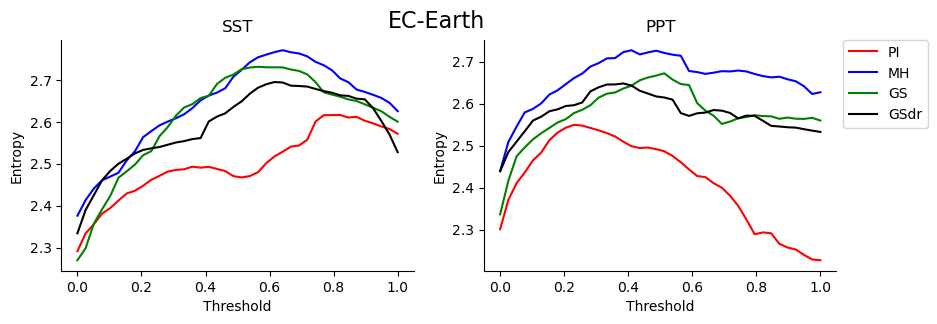

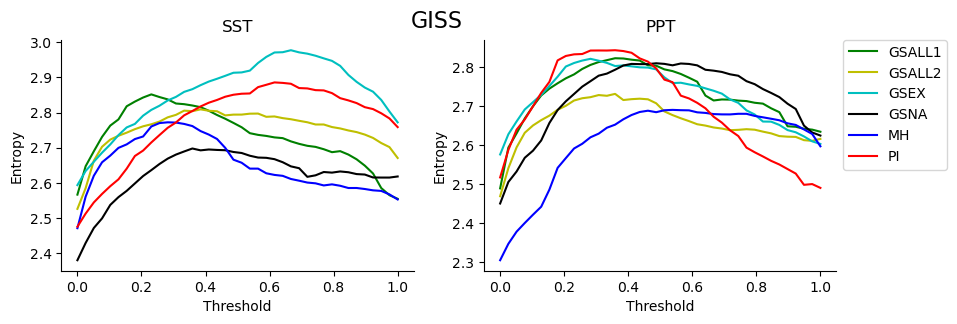

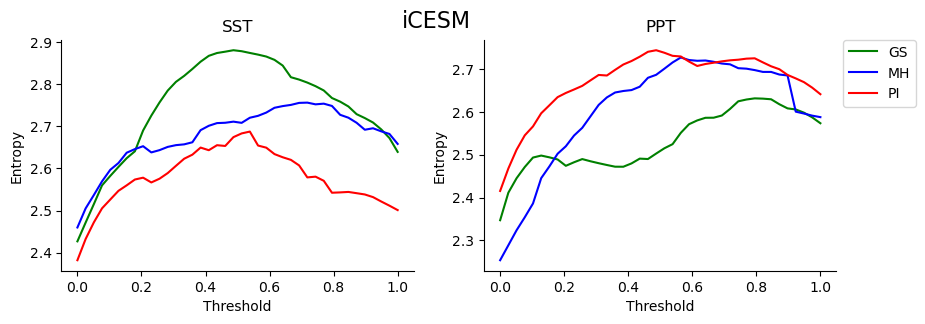

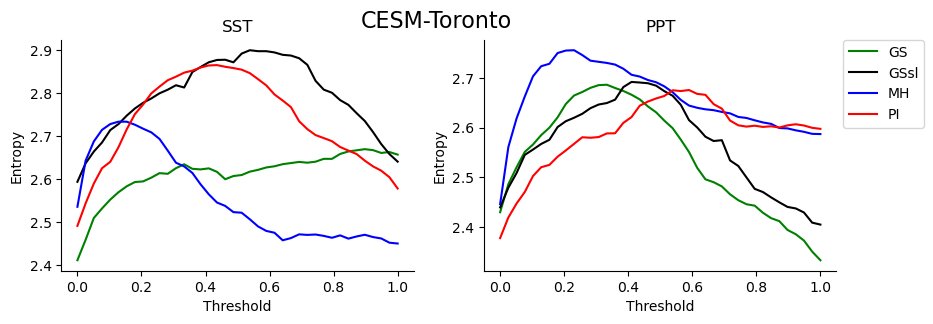

In [824]:
# THRESHOLD PLOTS, COM DUAS DIMENSOES DE TRESHOLD FIXAS NO VALOR OTIMO....

model=['EC-Earth','EC-Earth','EC-Earth','EC-Earth','GISS','GISS','GISS','GISS','GISS','GISS','iCESM','iCESM','iCESM','CCSM-T','CCSM-T','CCSM-T','CCSM-T']
cenario=['PI','MH','GS','GSdr','GSALL1','GSALL2','GSEX','GSNA','MH','PI','GS','MH','PI','GS','GSsl','MH','PI']

fig = plt.figure(figsize=(10,3))
fig.suptitle('EC-Earth', fontsize=16)

ax = fig.add_subplot(1, 2, 1)

m=-1
for cen in cenario[0:4]:
    m+=1
    if cen =='PI':
        plt.plot(ncs,ys[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncs,ys[m], color = 'b', label=cenario[m])
    elif cen =='GS':
        plt.plot(ncs,ys[m], color = 'g', label=cenario[m])
    elif cen =='GSdr':
        plt.plot(ncs,ys[m], color = 'k', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('SST')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)


ax = fig.add_subplot(1, 2, 2)

m=-1
for cen in cenario[0:4]:
    m+=1
    if cen =='PI':
        plt.plot(ncp,yp[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncp,yp[m], color = 'b', label=cenario[m])
    elif cen =='GS':
        plt.plot(ncp,yp[m], color = 'g', label=cenario[m])
    elif cen =='GSdr':
        plt.plot(ncp,yp[m], color = 'k', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('PPT')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)

#GISS

fig = plt.figure(figsize=(10,3))
fig.suptitle('GISS', fontsize=16)

ax = fig.add_subplot(1, 2, 1)
m=3
for cen in cenario[4:10]:
    m+=1
    if cen =='PI':
        plt.plot(ncs,ys[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncs,ys[m], color = 'b', label=cenario[m])
    elif cen =='GSALL1':
        plt.plot(ncs,ys[m], color = 'g', label=cenario[m])
    elif cen =='GSALL2':
        plt.plot(ncs,ys[m], color = 'y', label=cenario[m])
    elif cen =='GSNA':
        plt.plot(ncs,ys[m], color = 'k', label=cenario[m])
    elif cen =='GSEX':
        plt.plot(ncs,ys[m], color = 'c', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('SST')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)

ax = fig.add_subplot(1, 2, 2)
m=3
for cen in cenario[4:10]:
    m+=1
    if cen =='PI':
        plt.plot(ncp,yp[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncp,yp[m], color = 'b', label=cenario[m])
    elif cen =='GSALL1':
        plt.plot(ncp,yp[m], color = 'g', label=cenario[m])
    elif cen =='GSALL2':
        plt.plot(ncp,yp[m], color = 'y', label=cenario[m])
    elif cen =='GSNA':
        plt.plot(ncp,yp[m], color = 'k', label=cenario[m])
    elif cen =='GSEX':
        plt.plot(ncp,yp[m], color = 'c', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('PPT')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)

#iCESM

fig = plt.figure(figsize=(10,3))
fig.suptitle('iCESM', fontsize=16)

ax = fig.add_subplot(1, 2, 1)
m=9
for cen in cenario[10:13]:
    m+=1
    if cen =='PI':
        plt.plot(ncs,ys[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncs,ys[m], color = 'b', label=cenario[m])
    elif cen =='GS':
        plt.plot(ncs,ys[m], color = 'g', label=cenario[m])
    elif cen =='GSdr':
        plt.plot(ncs,ys[m], color = 'k', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('SST')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)

ax = fig.add_subplot(1, 2, 2)
m=9
for cen in cenario[10:13]:
    m+=1
    if cen =='PI':
        plt.plot(ncp,yp[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncp,yp[m], color = 'b', label=cenario[m])
    elif cen =='GS':
        plt.plot(ncp,yp[m], color = 'g', label=cenario[m])
    elif cen =='GSdr':
        plt.plot(ncp,yp[m], color = 'k', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('PPT')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)


# TORONTO

fig = plt.figure(figsize=(10,3))
fig.suptitle('CESM-Toronto', fontsize=16)

ax = fig.add_subplot(1, 2, 1)
m=12
for cen in cenario[13:]:
    m+=1
    if cen =='PI':
        plt.plot(ncs,ys[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncs,ys[m], color = 'b', label=cenario[m])
    elif cen =='GS':
        plt.plot(ncs,ys[m], color = 'g', label=cenario[m])
    elif cen =='GSsl':
        plt.plot(ncs,ys[m], color = 'k', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('SST')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)

ax = fig.add_subplot(1, 2, 2)
m=12
for cen in cenario[13:]:
    m+=1 
    if cen =='PI':
        plt.plot(ncp,yp[m], color = 'r', label=cenario[m])
    elif cen =='MH':
        plt.plot(ncp,yp[m], color = 'b', label=cenario[m])
    elif cen =='GS':
        plt.plot(ncp,yp[m], color = 'g', label=cenario[m])
    elif cen =='GSsl':
        plt.plot(ncp,yp[m], color = 'k', label=cenario[m])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('Entropy')
    ax.set_xlabel('Threshold')
    ax.set_title('PPT')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#plt.axvline(x=0.2, ls='--',alpha=0.5)
#plt.axvline(x=0.75, ls='--',alpha=0.5)

In [65]:
# CHECK DO QUE ESTA EM CADA VETOR USADO NOS PLOTS...

for mod,cen,entropia,STD in zip(model,cenario,entropias,STDs):
    print(mod,cen,entropia,STD)
    
for mod,cen,entropia,STD in zip(model,cenario,entropiap,STDp):
    print(mod,cen,entropia,STD)

EC-Earth PI 2.92 0.07678794406534006
EC-Earth MH 2.98 0.04463043334245942
EC-Earth GS 3.09 0.06212548880376678
EC-Earth GSdr 2.94 0.060002770807994654
GISS GSALL1 3.2 0.049079853880398705
GISS GSALL2 3.1 0.05959186265355276
GISS GSEX 3.02 0.05400810591091032
GISS GSNA 3.19 0.0432010152998239
GISS MH 3.14 0.053677679504402054
GISS PI 3.06 0.056677649927900475
iCESM GS 3.17 0.04765182473639884
iCESM MH 3.15 0.06109195267678302
iCESM PI 2.98 0.060167964487221504
CCSM-T GS 3.05 0.06151620605353836
CCSM-T GSsl 3.01 0.06921080270536173
CCSM-T MH 3.09 0.058020156060255346
CCSM-T PI 3.11 0.051318171386442124
EC-Earth PI 3.0 0.06509968698993474
EC-Earth MH 3.09 0.050523694678377584
EC-Earth GS 2.96 0.06803341780005612
EC-Earth GSdr 3.17 0.05149865090993533
GISS GSALL1 3.1 0.06660805404076342
GISS GSALL2 3.04 0.05196220914735239
GISS GSEX 3.17 0.056106050241461425
GISS GSNA 3.12 0.053319455837020246
GISS MH 3.16 0.054150183939756236
GISS PI 3.15 0.049266533654880096
iCESM GS 2.92 0.0736707456982

Text(0.75, 2.84321205593466, 'EC-Earth')

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(0.75, 2.9349003130100653, 'EC-Earth')

Text(1.0, 3.1166776499279005, 'GISS')

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(1.0, 3.19926653365488, 'GISS')

Text(1.25, 3.0101679644872217, 'iCESM')

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(1.25, 3.0808625798022318, 'iCESM')

Text(1.5, 3.161318171386442, 'CCSM-T')

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(1.5, 3.220342550086367, 'CCSM-T')

Text(3.75, 2.9353695666575406, 'EC-Earth')

<ErrorbarContainer object of 3 artists>

Text(3.75, 3.049476305321622, 'EC-Earth')

<ErrorbarContainer object of 3 artists>

Text(4.0, 3.173677679504402, 'GISS')

<ErrorbarContainer object of 3 artists>

Text(4.0, 3.105849816060244, 'GISS')

<ErrorbarContainer object of 3 artists>

Text(4.25, 3.211091952676783, 'iCESM')

<ErrorbarContainer object of 3 artists>

Text(4.25, 3.2331366811563433, 'iCESM')

<ErrorbarContainer object of 3 artists>

Text(4.5, 3.148020156060255, 'CCSM-T')

<ErrorbarContainer object of 3 artists>

Text(4.5, 3.083727339128696, 'CCSM-T')

<ErrorbarContainer object of 3 artists>

Text(6.75, 3.0178745111962333, 'EC-Earth')

<ErrorbarContainer object of 3 artists>

Text(6.75, 2.881966582199944, 'EC-Earth')

<ErrorbarContainer object of 3 artists>

Text(6.972222222222222, 2.8699972291920055, 'EC-Earthdr')

<ErrorbarContainer object of 3 artists>

Text(6.972222222222222, 3.2214986509099353, 'EC-Earthdr')

<ErrorbarContainer object of 3 artists>

Text(7.194444444444445, 3.239079853880399, 'GISSall1')

<ErrorbarContainer object of 3 artists>

Text(7.194444444444445, 3.0533919459592367, 'GISSall1')

<ErrorbarContainer object of 3 artists>

Text(7.416666666666667, 3.1080201560602556, 'GISSall2')

<ErrorbarContainer object of 3 artists>

Text(7.416666666666667, 2.978037790852648, 'GISSall2')

<ErrorbarContainer object of 3 artists>

Text(7.638888888888889, 3.0640081059109106, 'GISSex')

<ErrorbarContainer object of 3 artists>

Text(7.638888888888889, 3.1861060502414618, 'GISSex')

<ErrorbarContainer object of 3 artists>

Text(7.861111111111111, 3.223201015299824, 'GISSna')

<ErrorbarContainer object of 3 artists>

Text(7.861111111111111, 3.1333194558370208, 'GISSna')

<ErrorbarContainer object of 3 artists>

Text(8.083333333333334, 3.187651824736399, 'iCESM')

<ErrorbarContainer object of 3 artists>

Text(8.083333333333334, 2.866329254301736, 'iCESM')

<ErrorbarContainer object of 3 artists>

Text(8.305555555555555, 3.1015162060535384, 'CCSM-T')

<ErrorbarContainer object of 3 artists>

Text(8.305555555555555, 3.0588983362570143, 'CCSM-T')

<ErrorbarContainer object of 3 artists>

Text(8.527777777777779, 3.0692108027053617, 'CCSM-Tsl')

<ErrorbarContainer object of 3 artists>

Text(8.527777777777779, 3.098588170723358, 'CCSM-Tsl')

<ErrorbarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x7f6c4b7fdff0>,
 [Text(1.5, 0, 'PI'), Text(4.2, 0, 'MH'), Text(8.5, 0, 'GS')])

Text(0, 0.5, 'Entropy')

[]

Text(0, 0.5, 'Entropy')

Text(0.5, 0, 'Experiment')

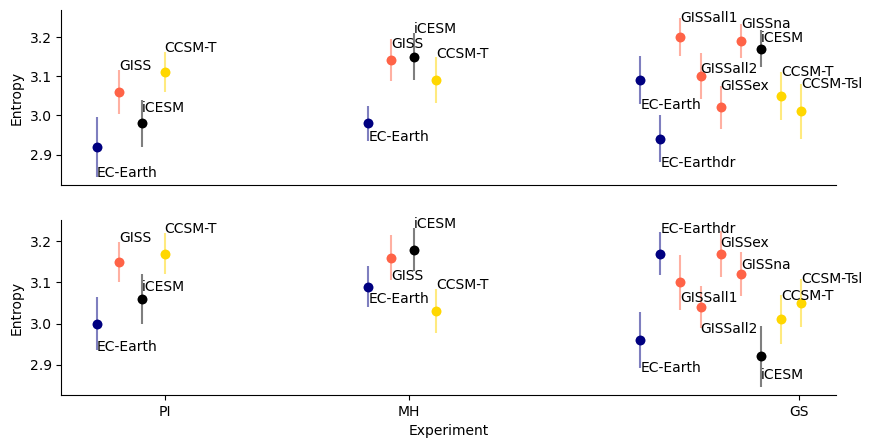

In [102]:
## SST

n=0 # contador
PI=[]
PIstd=[]
MH=[]
MHstd=[]
GS=[]
GSstd=[]

for cen in cenario:
    if cen == 'PI':
        PI.append(entropias[n])
        PIstd.append(STDs[n])
    elif cen == 'MH':
        MH.append(entropias[n])
        MHstd.append(STDs[n])
    else:
        GS.append(entropias[n])
        GSstd.append(STDs[n])
    n+=1
## Precipitation

n=0 # contador
PIp=[]
PIstdp=[]
MHp=[]
MHstdp=[]
GSp=[]
GSstdp=[]

for cen in cenario:
    if cen == 'PI':
        PIp.append(entropiap[n])
        PIstdp.append(STDp[n])
    elif cen == 'MH':
        MHp.append(entropiap[n])
        MHstdp.append(STDp[n])
    else:
        GSp.append(entropiap[n])
        GSstdp.append(STDp[n])
    n+=1

modelPI=['EC-Earth','GISS','iCESM','CCSM-T']
modelGS=['EC-Earth','EC-Earthdr','GISSall1','GISSall2','GISSex','GISSna','iCESM','CCSM-T','CCSM-Tsl']

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(2, 1, 1) #SST
ay = fig.add_subplot(2, 1, 2) # PPT
    
for n in range(len(PI)):
    x=0.75+n/(len(PI))
    
    if modelPI[n]=='GISS':
        color = 'tomato'
        deslocp=PIstdp[n]
        desloc= PIstd[n]
     
    elif modelPI[n]=='EC-Earth':
        color = 'navy'
        deslocp=-PIstdp[n]
        desloc= -PIstd[n]
    
    elif modelPI[n]=='CCSM-T':
        color = 'gold'
        deslocp=PIstdp[n]
        desloc= PIstd[n]
        
    elif modelPI[n]=='iCESM':
        color = 'k'
        deslocp=PIstdp[n]-0.04
        desloc= PIstd[n]-0.03
        
    # PlOT SST
    ax.annotate(modelPI[n], (x, PI[n]+desloc))
    ax.scatter(x, PI[n],color=color)
    ax.errorbar(x, PI[n], yerr=PIstd[n], fmt="o",alpha=0.5,color=color)
    # PLOT PPT
    ay.scatter(x, PIp[n],color=color)
    ay.errorbar(x, PIp[n], yerr=PIstdp[n], fmt="o",alpha=0.5,color=color)
    ay.annotate(modelPI[n], (x, PIp[n]+deslocp))
    
 
for n in range(len(MH)):
    x=3.75+n/len(MH)
    
    if modelPI[n]=='GISS':
        color = 'tomato'
        deslocp=-MHstdp[n]
        desloc= MHstd[n]-0.02
     
    elif modelPI[n]=='EC-Earth':
        color = 'navy'
        deslocp=-MHstdp[n]+0.01
        desloc= -MHstd[n]
    
    elif modelPI[n]=='CCSM-T':
        color = 'gold'
        deslocp=MHstdp[n]
        desloc= MHstd[n]
        
    elif modelPI[n]=='iCESM':
        color = 'k'
        deslocp=MHstdp[n]
        desloc= MHstd[n]
        
    # SST
    ax.annotate(modelPI[n], (x, MH[n]+desloc))
    ax.scatter(x, MH[n],color=color)
    ax.errorbar(x, MH[n], yerr=MHstd[n], fmt="o",alpha=0.5,color=color)
    
    ## PPT
    ay.annotate(modelPI[n], (x, MHp[n]+deslocp)) 
    ay.scatter(x, MHp[n],color=color)
    ay.errorbar(x, MHp[n], yerr=MHstdp[n], fmt="o",alpha=0.5,color=color)
       
    
for n in range(len(GS)):
    x=6.75+n*2/len(GS)
    if modelGS[n][:4]=='GISS':
        color = 'tomato'
        deslocp=GSstdp[n]
        desloc= GSstd[n]
        if modelGS[n][-1] =='2':
            desloc= MHstd[n]-0.04
            deslocp=-GSstdp[n]
        if modelGS[n][-1] =='1':
            deslocp=-GSstdp[n]+0.03
        elif modelGS[n][-1] =='x' or modelGS[n][-1] =='a':
            deslocp=GSstdp[n]-0.03
        
    elif modelGS[n][:8]=='EC-Earth':
        color = 'navy'
        deslocp=-GSstdp[n]
        desloc= -GSstd[n]
        if modelGS[n][-1]=='r':
            deslocp=GSstdp[n]+0.01
            
    elif modelGS[n][:6]=='CCSM-T':
        color = 'gold'
        deslocp=GSstdp[n]
        desloc= GSstd[n]
        
    elif modelGS[n][:5]=='iCESM':
        color = 'k'
        deslocp=-GSstdp[n]+0.03
        desloc= GSstd[n]-0.02
        
    # PLTO SST
    ax.annotate(modelGS[n], (x, GS[n]+desloc-.01))
    ax.scatter(x, GS[n],label=modelGS[n],color=color)
    ax.errorbar(x, GS[n], yerr=GSstd[n], fmt="o",alpha=0.5,color=color)
    # PLOT PPT
    ay.annotate(modelGS[n], (x, GSp[n]+deslocp-.01)) 
    ay.scatter(x, GSp[n],color=color)
    ay.errorbar(x, GSp[n], yerr=GSstdp[n], fmt="o",alpha=0.5,color=color)

x=[1.5,4.2,8.5]
my_xticks = ['PI','MH','GS']
plt.xticks(x, my_xticks)
ax.set_ylabel('Entropy')
ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)
#ax.title.set_text('SST')
ay.set_ylabel('Entropy')
ay.set_xlabel('Experiment')
ay.spines[['right', 'top']].set_visible(False)
#ay.title.set_text('PPT')

    
plt.show()     

## System States
Needs the original sea surface temperature and precipitation vectors with lat and lon from simulations
Available upon reasonable request to the Corresponding Author (Iuri Gorenstein)

##### 27 SYSTEM STATES PLOT

/tmp/ipykernel_23462/4196832669.py:38: RuntimeWarning: Mean of empty slice
  im = ax.contourf(lon, lat, np.nanmean(vetor[masc],axis=0),levels=levels,cmap=cmap,extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'


Text(0.5, 1.0, 'State 0')

Text(0.5, 1.0, 'State 1')

Text(0.5, 1.0, 'State 2')

Text(0.5, 1.0, 'State 3')

Text(0.5, 1.0, 'State 4')

Text(0.5, 1.0, 'State 5')

Text(0.5, 1.0, 'State 6')

Text(0.5, 1.0, 'State 7')

Text(0.5, 1.0, 'State 8')

Text(0.5, 1.0, 'State 9')

Text(0.5, 1.0, 'State 10')

Text(0.5, 1.0, 'State 11')

Text(0.5, 1.0, 'State 12')

Text(0.5, 1.0, 'State 13')

Text(0.5, 1.0, 'State 14')

Text(0.5, 1.0, 'State 15')

Text(0.5, 1.0, 'State 16')

Text(0.5, 1.0, 'State 17')

Text(0.5, 1.0, 'State 18')

Text(0.5, 1.0, 'State 19')

Text(0.5, 1.0, 'State 20')

Text(0.5, 1.0, 'State 21')

Text(0.5, 1.0, 'State 22')

Text(0.5, 1.0, 'State 23')

Text(0.5, 1.0, 'State 24')

Text(0.5, 1.0, 'State 25')

Text(0.5, 1.0, 'State 26')

locator: <matplotlib.ticker.FixedLocator object at 0x7f6c12433af0>
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so

Text(0.5, 1.0, 'State 0')

Text(0.5, 1.0, 'State 1')

Text(0.5, 1.0, 'State 2')

Text(0.5, 1.0, 'State 3')

Text(0.5, 1.0, 'State 4')

Text(0.5, 1.0, 'State 5')

Text(0.5, 1.0, 'State 6')

Text(0.5, 1.0, 'State 7')

Text(0.5, 1.0, 'State 8')

Text(0.5, 1.0, 'State 9')

Text(0.5, 1.0, 'State 10')

Text(0.5, 1.0, 'State 11')

Text(0.5, 1.0, 'State 12')

Text(0.5, 1.0, 'State 13')

Text(0.5, 1.0, 'State 14')

Text(0.5, 1.0, 'State 15')

Text(0.5, 1.0, 'State 16')

Text(0.5, 1.0, 'State 17')

Text(0.5, 1.0, 'State 18')

Text(0.5, 1.0, 'State 19')

Text(0.5, 1.0, 'State 20')

Text(0.5, 1.0, 'State 21')

Text(0.5, 1.0, 'State 22')

Text(0.5, 1.0, 'State 23')

Text(0.5, 1.0, 'State 24')

Text(0.5, 1.0, 'State 25')

Text(0.5, 1.0, 'State 26')

locator: <matplotlib.ticker.FixedLocator object at 0x7f6c15478a90>
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so

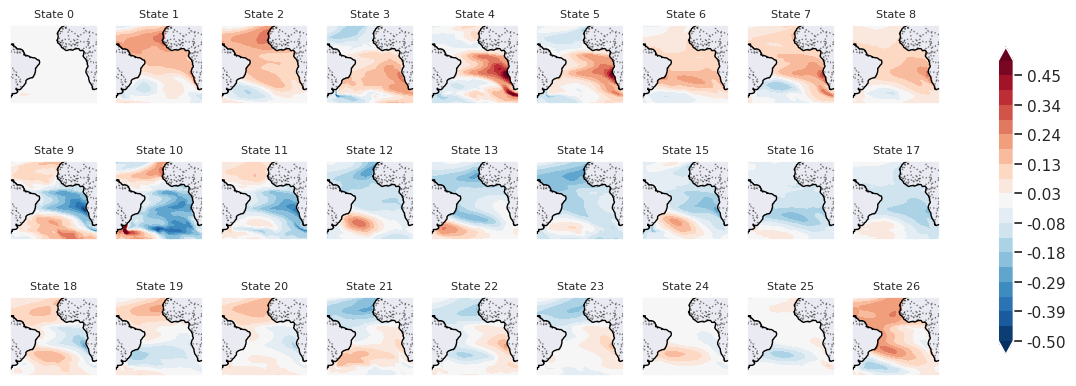

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


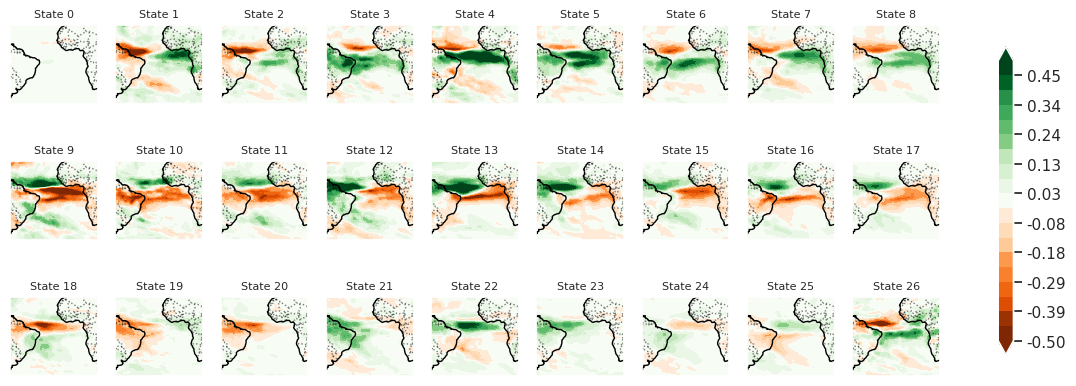

In [130]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

level = 0.5
levels = np.linspace(-level,level, 20)

### CMAP PARA CHUVA ############################
top = cm.get_cmap('Greens', 12)
bottom = cm.get_cmap('Oranges_r', 12)
newcolors = np.vstack((bottom(np.linspace(0, 1, 12)),
                       top(np.linspace(0, 1, 12))))
cmpchuva = ListedColormap(newcolors, name='OrangeGreen')
################################################

modos = [ 'sst','ppt' ]

for modo in modos:
    
    sns.set_theme(rc={'figure.figsize':(15,5)})
    fig, axes = plt.subplots(3, 9, subplot_kw={'projection': ccrs.PlateCarree()})
    
    if modo == 'sst':
        cluster = np.concatenate(cluster_sst,axis=0)
        cmap = "RdBu_r"
        vetor = Vtosa
    elif modo == 'ppt':
        cluster = np.concatenate(cluster_ppt,axis=0)
        cmap=cmpchuva
        vetor = Vppta

    for c,ax in enumerate(axes.flatten()): # estados possiveis, sao 27
        
        #mascara de clusters
        masc = ( cluster == c )
        
        ## PLOT #########################################
        #ax.set_extent([-65, 24, -49, 29.5], ccrs.PlateCarree())
        im = ax.contourf(lon, lat, np.nanmean(vetor[masc],axis=0),levels=levels,cmap=cmap,extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'         
        ax.coastlines(linewidths=1)
        ax.add_feature(cf.BORDERS, linestyle=':', alpha=.5)
        ax.set_title('State ' + str(c), fontsize=8)
    
    # Customize colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8)
    #cbar.ax.yaxis.set_major_locator(MaxNLocator(5))  # Set maximum number of ticks
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Format ticks to 2 decimal places



    # Save the figure
    save_folder = '/home/iuri/xesmf/27StatePlots'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    plt.savefig(os.path.join(save_folder, modo+'.png'))